# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

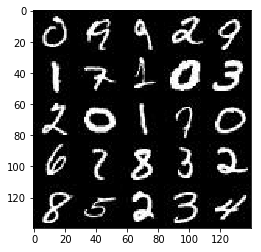

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

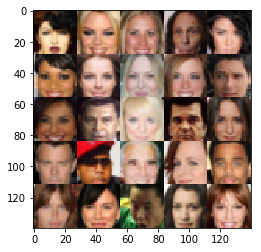

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32,
                                       (None, image_width, image_height, image_channels),
                                       name="real_input_images")
    
    z_data = tf.placeholder(tf.float32, (None, z_dim), name="z_data")
    
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # Conv. 1
        layer_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        layer_1 = tf.maximum(alpha*layer_1, layer_1)
        
        # Conv. 2
        layer_2 = tf.layers.conv2d(layer_1, 128, 5, strides=2, padding="same")
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha*layer_2, layer_2)
        
        # Conv. 3
        layer_3 = tf.layers.conv2d(layer_2, 256, 5, strides=2, padding="same")
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha*layer_3, layer_3)
        
        # Conv. 4
        layer_4 = tf.layers.conv2d(layer_3, 512, 5, strides=1, padding="same")
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha*layer_4, layer_4)
        
        # Flatten
        logits = tf.reshape(layer_4, [-1, 4*4*256])
        logits = tf.layers.dense(logits, 1)
        
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope("generator", reuse=(not is_train)):
        # Fully connected
        layer_1 = tf.layers.dense(z, 2*2*512)
        layer_1 = tf.reshape(layer_1, [-1, 2, 2, 512])
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha*layer_1, layer_1)

        # Trans. conv. 1
        layer_2 = tf.layers.conv2d_transpose(layer_1, 256, 5, strides=2, padding="valid")
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha*layer_2, layer_2)

        # Trans. conv. 2
        layer_3 = tf.layers.conv2d_transpose(layer_2, 128, 5, strides=2, padding="same")
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha*layer_3, layer_3)
        
        # Trans. conv. 3
        layer_4 = tf.layers.conv2d_transpose(layer_3, 64, 5, strides=1, padding="same")
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = tf.maximum(alpha*layer_4, layer_4)
        
        # Trans. conv. 3
        logits = tf.layers.conv2d_transpose(layer_4, out_channel_dim, 5, strides=2, padding="same")
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Get outputs and logits
    g_output = generator(input_z, out_channel_dim, is_train=True)
    
    d_output_x, d_logits_x = discriminator(input_real, reuse=False)
    d_output_z, d_logits_z = discriminator(g_output, reuse=True)
    
    # Get losses
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_z,
            labels=tf.ones_like(d_logits_z)))
    
    d_loss_x = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_x,
            labels=tf.ones_like(d_logits_x)*0.9))
    d_loss_z = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_z,
            labels=tf.zeros_like(d_logits_z)))
    d_loss = tf.add(d_loss_x, d_loss_z)
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [x for x in t_vars if x.name.startswith("discriminator")]
    g_vars = [x for x in t_vars if x.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    x_images, z_images, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(x_images, z_images, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            
            batch_num = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                batch_num += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images * 2
                
                z_data = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={
                        x_images: batch_images,
                        z_images: z_data,
                        learn_rate: learning_rate
                    })
                
                sess.run(g_opt, feed_dict={
                        x_images: batch_images,
                        z_images: z_data,
                        learn_rate: learning_rate
                    })
                sess.run(g_opt, feed_dict={
                        x_images: batch_images,
                        z_images: z_data,
                        learn_rate: learning_rate
                    })
                
                if (batch_num % 10 == 0):
                    d_train_loss = d_loss.eval({x_images: batch_images, z_images: z_data})
                    g_train_loss = g_loss.eval({x_images: batch_images, z_images: z_data})
                    
                    print("Epoch: {}/{}, Batch: {}/{}".format(epoch_i+1, epoch_count, batch_num, data_shape[0]//batch_size),
                         "Discriminator Loss: {:.4f}".format(d_train_loss),
                         "Generator Loss: {:.4f}".format(g_train_loss))
                
                if (batch_num % 100 == 0):
                    show_generator_output(sess, 9, z_images, data_shape[3], data_image_mode)
                    
            show_generator_output(sess, 16, z_images, data_shape[3], data_image_mode) 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2, Batch: 10/1875 Discriminator Loss: 3.0047 Generator Loss: 2.0992
Epoch: 1/2, Batch: 20/1875 Discriminator Loss: 2.3293 Generator Loss: 4.8262
Epoch: 1/2, Batch: 30/1875 Discriminator Loss: 2.0345 Generator Loss: 1.4113
Epoch: 1/2, Batch: 40/1875 Discriminator Loss: 1.8305 Generator Loss: 6.4108
Epoch: 1/2, Batch: 50/1875 Discriminator Loss: 1.6338 Generator Loss: 0.6528
Epoch: 1/2, Batch: 60/1875 Discriminator Loss: 0.8182 Generator Loss: 1.1871
Epoch: 1/2, Batch: 70/1875 Discriminator Loss: 0.7391 Generator Loss: 1.5005
Epoch: 1/2, Batch: 80/1875 Discriminator Loss: 1.2133 Generator Loss: 0.7049
Epoch: 1/2, Batch: 90/1875 Discriminator Loss: 0.7666 Generator Loss: 2.4999
Epoch: 1/2, Batch: 100/1875 Discriminator Loss: 1.7049 Generator Loss: 0.5078


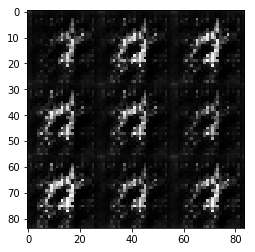

Epoch: 1/2, Batch: 110/1875 Discriminator Loss: 0.9053 Generator Loss: 1.2900
Epoch: 1/2, Batch: 120/1875 Discriminator Loss: 0.9044 Generator Loss: 2.0571
Epoch: 1/2, Batch: 130/1875 Discriminator Loss: 0.9676 Generator Loss: 0.9217
Epoch: 1/2, Batch: 140/1875 Discriminator Loss: 1.1756 Generator Loss: 1.1040
Epoch: 1/2, Batch: 150/1875 Discriminator Loss: 2.7079 Generator Loss: 0.2192
Epoch: 1/2, Batch: 160/1875 Discriminator Loss: 1.6451 Generator Loss: 0.5455
Epoch: 1/2, Batch: 170/1875 Discriminator Loss: 0.9722 Generator Loss: 1.1671
Epoch: 1/2, Batch: 180/1875 Discriminator Loss: 1.0479 Generator Loss: 1.4065
Epoch: 1/2, Batch: 190/1875 Discriminator Loss: 0.7820 Generator Loss: 2.2890
Epoch: 1/2, Batch: 200/1875 Discriminator Loss: 1.1092 Generator Loss: 1.3564


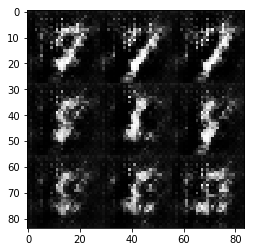

Epoch: 1/2, Batch: 210/1875 Discriminator Loss: 1.4216 Generator Loss: 0.7543
Epoch: 1/2, Batch: 220/1875 Discriminator Loss: 1.1624 Generator Loss: 0.8291
Epoch: 1/2, Batch: 230/1875 Discriminator Loss: 1.1102 Generator Loss: 1.1022
Epoch: 1/2, Batch: 240/1875 Discriminator Loss: 1.2075 Generator Loss: 1.0495
Epoch: 1/2, Batch: 250/1875 Discriminator Loss: 0.9600 Generator Loss: 1.4460
Epoch: 1/2, Batch: 260/1875 Discriminator Loss: 1.5523 Generator Loss: 0.8557
Epoch: 1/2, Batch: 270/1875 Discriminator Loss: 1.4507 Generator Loss: 0.8749
Epoch: 1/2, Batch: 280/1875 Discriminator Loss: 1.4495 Generator Loss: 0.8767
Epoch: 1/2, Batch: 290/1875 Discriminator Loss: 1.3968 Generator Loss: 0.6090
Epoch: 1/2, Batch: 300/1875 Discriminator Loss: 1.3557 Generator Loss: 0.6684


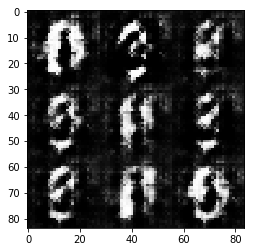

Epoch: 1/2, Batch: 310/1875 Discriminator Loss: 1.2422 Generator Loss: 1.4994
Epoch: 1/2, Batch: 320/1875 Discriminator Loss: 1.0703 Generator Loss: 1.3922
Epoch: 1/2, Batch: 330/1875 Discriminator Loss: 1.1431 Generator Loss: 1.0268
Epoch: 1/2, Batch: 340/1875 Discriminator Loss: 1.3959 Generator Loss: 0.8285
Epoch: 1/2, Batch: 350/1875 Discriminator Loss: 1.1895 Generator Loss: 1.2904
Epoch: 1/2, Batch: 360/1875 Discriminator Loss: 1.1995 Generator Loss: 0.9598
Epoch: 1/2, Batch: 370/1875 Discriminator Loss: 1.2447 Generator Loss: 0.6915
Epoch: 1/2, Batch: 380/1875 Discriminator Loss: 1.3635 Generator Loss: 1.3197
Epoch: 1/2, Batch: 390/1875 Discriminator Loss: 1.4910 Generator Loss: 1.4903
Epoch: 1/2, Batch: 400/1875 Discriminator Loss: 1.2911 Generator Loss: 0.8567


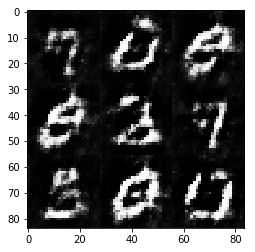

Epoch: 1/2, Batch: 410/1875 Discriminator Loss: 1.4517 Generator Loss: 0.6238
Epoch: 1/2, Batch: 420/1875 Discriminator Loss: 1.3114 Generator Loss: 0.9353
Epoch: 1/2, Batch: 430/1875 Discriminator Loss: 1.2853 Generator Loss: 0.8384
Epoch: 1/2, Batch: 440/1875 Discriminator Loss: 1.2618 Generator Loss: 0.6754
Epoch: 1/2, Batch: 450/1875 Discriminator Loss: 1.1703 Generator Loss: 1.0933
Epoch: 1/2, Batch: 460/1875 Discriminator Loss: 1.3624 Generator Loss: 0.7054
Epoch: 1/2, Batch: 470/1875 Discriminator Loss: 1.3182 Generator Loss: 0.8914
Epoch: 1/2, Batch: 480/1875 Discriminator Loss: 1.5276 Generator Loss: 1.2070
Epoch: 1/2, Batch: 490/1875 Discriminator Loss: 1.3364 Generator Loss: 0.7034
Epoch: 1/2, Batch: 500/1875 Discriminator Loss: 1.0881 Generator Loss: 1.0429


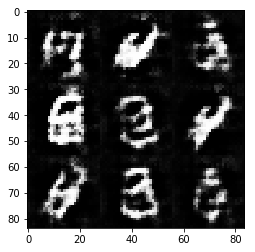

Epoch: 1/2, Batch: 510/1875 Discriminator Loss: 1.2743 Generator Loss: 1.5046
Epoch: 1/2, Batch: 520/1875 Discriminator Loss: 1.4712 Generator Loss: 0.7530
Epoch: 1/2, Batch: 530/1875 Discriminator Loss: 1.2433 Generator Loss: 0.9953
Epoch: 1/2, Batch: 540/1875 Discriminator Loss: 1.2703 Generator Loss: 0.9332
Epoch: 1/2, Batch: 550/1875 Discriminator Loss: 1.2667 Generator Loss: 0.7188
Epoch: 1/2, Batch: 560/1875 Discriminator Loss: 1.2769 Generator Loss: 0.8521
Epoch: 1/2, Batch: 570/1875 Discriminator Loss: 1.3659 Generator Loss: 0.6957
Epoch: 1/2, Batch: 580/1875 Discriminator Loss: 1.1128 Generator Loss: 1.0343
Epoch: 1/2, Batch: 590/1875 Discriminator Loss: 1.1798 Generator Loss: 1.4771
Epoch: 1/2, Batch: 600/1875 Discriminator Loss: 1.3235 Generator Loss: 0.7156


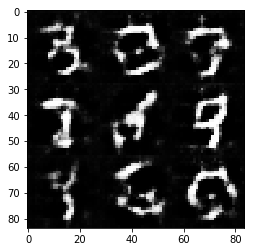

Epoch: 1/2, Batch: 610/1875 Discriminator Loss: 1.2941 Generator Loss: 0.7379
Epoch: 1/2, Batch: 620/1875 Discriminator Loss: 1.5765 Generator Loss: 1.2982
Epoch: 1/2, Batch: 630/1875 Discriminator Loss: 1.4643 Generator Loss: 0.5533
Epoch: 1/2, Batch: 640/1875 Discriminator Loss: 1.3487 Generator Loss: 0.5088
Epoch: 1/2, Batch: 650/1875 Discriminator Loss: 1.6202 Generator Loss: 0.4339
Epoch: 1/2, Batch: 660/1875 Discriminator Loss: 1.3455 Generator Loss: 0.8242
Epoch: 1/2, Batch: 670/1875 Discriminator Loss: 1.2521 Generator Loss: 1.1652
Epoch: 1/2, Batch: 680/1875 Discriminator Loss: 1.3379 Generator Loss: 0.9679
Epoch: 1/2, Batch: 690/1875 Discriminator Loss: 1.1818 Generator Loss: 1.0203
Epoch: 1/2, Batch: 700/1875 Discriminator Loss: 1.3426 Generator Loss: 0.6442


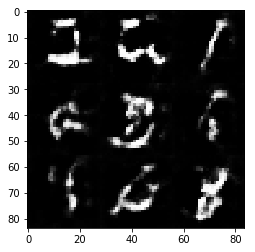

Epoch: 1/2, Batch: 710/1875 Discriminator Loss: 1.3654 Generator Loss: 1.1344
Epoch: 1/2, Batch: 720/1875 Discriminator Loss: 1.3741 Generator Loss: 0.7321
Epoch: 1/2, Batch: 730/1875 Discriminator Loss: 1.3043 Generator Loss: 0.6767
Epoch: 1/2, Batch: 740/1875 Discriminator Loss: 1.2773 Generator Loss: 1.2697
Epoch: 1/2, Batch: 750/1875 Discriminator Loss: 1.2480 Generator Loss: 0.8009
Epoch: 1/2, Batch: 760/1875 Discriminator Loss: 1.3582 Generator Loss: 0.5354
Epoch: 1/2, Batch: 770/1875 Discriminator Loss: 1.4953 Generator Loss: 0.5621
Epoch: 1/2, Batch: 780/1875 Discriminator Loss: 1.2884 Generator Loss: 1.2072
Epoch: 1/2, Batch: 790/1875 Discriminator Loss: 1.4481 Generator Loss: 0.5477
Epoch: 1/2, Batch: 800/1875 Discriminator Loss: 1.3136 Generator Loss: 0.7526


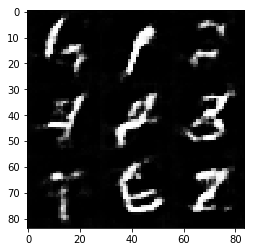

Epoch: 1/2, Batch: 810/1875 Discriminator Loss: 1.4437 Generator Loss: 0.8077
Epoch: 1/2, Batch: 820/1875 Discriminator Loss: 1.6121 Generator Loss: 1.3566
Epoch: 1/2, Batch: 830/1875 Discriminator Loss: 1.5447 Generator Loss: 0.4271
Epoch: 1/2, Batch: 840/1875 Discriminator Loss: 1.4255 Generator Loss: 0.6003
Epoch: 1/2, Batch: 850/1875 Discriminator Loss: 1.3018 Generator Loss: 0.8137
Epoch: 1/2, Batch: 860/1875 Discriminator Loss: 1.5735 Generator Loss: 0.4246
Epoch: 1/2, Batch: 870/1875 Discriminator Loss: 1.2305 Generator Loss: 1.0653
Epoch: 1/2, Batch: 880/1875 Discriminator Loss: 1.6718 Generator Loss: 0.4120
Epoch: 1/2, Batch: 890/1875 Discriminator Loss: 1.3966 Generator Loss: 0.5506
Epoch: 1/2, Batch: 900/1875 Discriminator Loss: 1.7152 Generator Loss: 0.3579


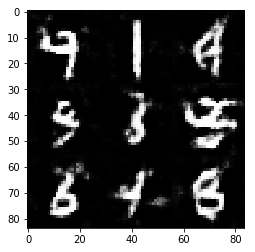

Epoch: 1/2, Batch: 910/1875 Discriminator Loss: 1.3194 Generator Loss: 0.6111
Epoch: 1/2, Batch: 920/1875 Discriminator Loss: 1.4189 Generator Loss: 1.1316
Epoch: 1/2, Batch: 930/1875 Discriminator Loss: 1.4890 Generator Loss: 0.4663
Epoch: 1/2, Batch: 940/1875 Discriminator Loss: 1.4007 Generator Loss: 0.6436
Epoch: 1/2, Batch: 950/1875 Discriminator Loss: 1.4055 Generator Loss: 0.8183
Epoch: 1/2, Batch: 960/1875 Discriminator Loss: 1.4319 Generator Loss: 0.6246
Epoch: 1/2, Batch: 970/1875 Discriminator Loss: 1.4100 Generator Loss: 0.6123
Epoch: 1/2, Batch: 980/1875 Discriminator Loss: 1.3487 Generator Loss: 0.6517
Epoch: 1/2, Batch: 990/1875 Discriminator Loss: 1.3619 Generator Loss: 1.3057
Epoch: 1/2, Batch: 1000/1875 Discriminator Loss: 1.3648 Generator Loss: 0.8925


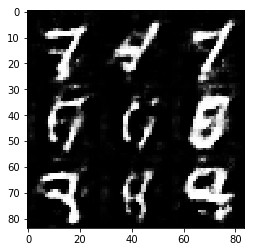

Epoch: 1/2, Batch: 1010/1875 Discriminator Loss: 1.5235 Generator Loss: 0.9369
Epoch: 1/2, Batch: 1020/1875 Discriminator Loss: 1.6511 Generator Loss: 0.9942
Epoch: 1/2, Batch: 1030/1875 Discriminator Loss: 1.4376 Generator Loss: 0.6329
Epoch: 1/2, Batch: 1040/1875 Discriminator Loss: 1.6715 Generator Loss: 0.3766
Epoch: 1/2, Batch: 1050/1875 Discriminator Loss: 1.3021 Generator Loss: 0.7893
Epoch: 1/2, Batch: 1060/1875 Discriminator Loss: 1.4439 Generator Loss: 0.7390
Epoch: 1/2, Batch: 1070/1875 Discriminator Loss: 1.4106 Generator Loss: 1.1375
Epoch: 1/2, Batch: 1080/1875 Discriminator Loss: 1.2965 Generator Loss: 0.5562
Epoch: 1/2, Batch: 1090/1875 Discriminator Loss: 1.3324 Generator Loss: 0.5881
Epoch: 1/2, Batch: 1100/1875 Discriminator Loss: 1.4557 Generator Loss: 0.6695


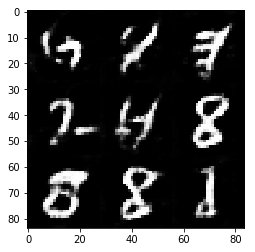

Epoch: 1/2, Batch: 1110/1875 Discriminator Loss: 2.0856 Generator Loss: 0.2162
Epoch: 1/2, Batch: 1120/1875 Discriminator Loss: 1.4651 Generator Loss: 0.6135
Epoch: 1/2, Batch: 1130/1875 Discriminator Loss: 1.5233 Generator Loss: 0.4887
Epoch: 1/2, Batch: 1140/1875 Discriminator Loss: 1.4748 Generator Loss: 0.7059
Epoch: 1/2, Batch: 1150/1875 Discriminator Loss: 1.5797 Generator Loss: 0.4359
Epoch: 1/2, Batch: 1160/1875 Discriminator Loss: 1.4906 Generator Loss: 0.4802
Epoch: 1/2, Batch: 1170/1875 Discriminator Loss: 1.6849 Generator Loss: 0.3620
Epoch: 1/2, Batch: 1180/1875 Discriminator Loss: 1.3677 Generator Loss: 0.6833
Epoch: 1/2, Batch: 1190/1875 Discriminator Loss: 2.2173 Generator Loss: 0.1996
Epoch: 1/2, Batch: 1200/1875 Discriminator Loss: 1.4598 Generator Loss: 0.5297


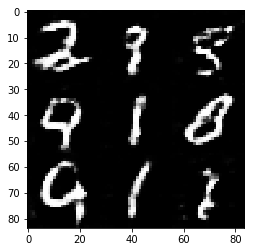

Epoch: 1/2, Batch: 1210/1875 Discriminator Loss: 1.3867 Generator Loss: 0.6032
Epoch: 1/2, Batch: 1220/1875 Discriminator Loss: 1.4125 Generator Loss: 0.8683
Epoch: 1/2, Batch: 1230/1875 Discriminator Loss: 1.3013 Generator Loss: 0.7535
Epoch: 1/2, Batch: 1240/1875 Discriminator Loss: 2.0443 Generator Loss: 2.2141
Epoch: 1/2, Batch: 1250/1875 Discriminator Loss: 1.5654 Generator Loss: 0.4463
Epoch: 1/2, Batch: 1260/1875 Discriminator Loss: 1.8373 Generator Loss: 0.3005
Epoch: 1/2, Batch: 1270/1875 Discriminator Loss: 1.1256 Generator Loss: 0.8596
Epoch: 1/2, Batch: 1280/1875 Discriminator Loss: 1.3405 Generator Loss: 1.1659
Epoch: 1/2, Batch: 1290/1875 Discriminator Loss: 1.4830 Generator Loss: 0.4358
Epoch: 1/2, Batch: 1300/1875 Discriminator Loss: 1.4974 Generator Loss: 0.8037


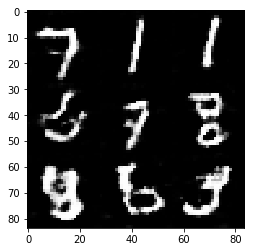

Epoch: 1/2, Batch: 1310/1875 Discriminator Loss: 1.9433 Generator Loss: 1.4894
Epoch: 1/2, Batch: 1320/1875 Discriminator Loss: 1.5364 Generator Loss: 0.4166
Epoch: 1/2, Batch: 1330/1875 Discriminator Loss: 1.0240 Generator Loss: 1.2309
Epoch: 1/2, Batch: 1340/1875 Discriminator Loss: 1.7452 Generator Loss: 0.3218
Epoch: 1/2, Batch: 1350/1875 Discriminator Loss: 2.0626 Generator Loss: 0.2255
Epoch: 1/2, Batch: 1360/1875 Discriminator Loss: 2.0935 Generator Loss: 0.2200
Epoch: 1/2, Batch: 1370/1875 Discriminator Loss: 1.6681 Generator Loss: 0.3888
Epoch: 1/2, Batch: 1380/1875 Discriminator Loss: 1.4068 Generator Loss: 0.5475
Epoch: 1/2, Batch: 1390/1875 Discriminator Loss: 1.3957 Generator Loss: 0.5870
Epoch: 1/2, Batch: 1400/1875 Discriminator Loss: 1.3760 Generator Loss: 0.6547


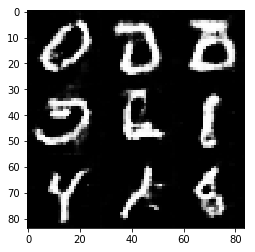

Epoch: 1/2, Batch: 1410/1875 Discriminator Loss: 1.3300 Generator Loss: 1.8070
Epoch: 1/2, Batch: 1420/1875 Discriminator Loss: 1.6217 Generator Loss: 0.3792
Epoch: 1/2, Batch: 1430/1875 Discriminator Loss: 1.4867 Generator Loss: 0.6256
Epoch: 1/2, Batch: 1440/1875 Discriminator Loss: 1.4537 Generator Loss: 0.5735
Epoch: 1/2, Batch: 1450/1875 Discriminator Loss: 1.6619 Generator Loss: 0.3734
Epoch: 1/2, Batch: 1460/1875 Discriminator Loss: 1.4178 Generator Loss: 0.5533
Epoch: 1/2, Batch: 1470/1875 Discriminator Loss: 1.5175 Generator Loss: 1.1796
Epoch: 1/2, Batch: 1480/1875 Discriminator Loss: 1.0167 Generator Loss: 1.2683
Epoch: 1/2, Batch: 1490/1875 Discriminator Loss: 1.4077 Generator Loss: 0.6186
Epoch: 1/2, Batch: 1500/1875 Discriminator Loss: 1.2922 Generator Loss: 0.8338


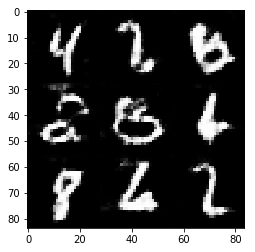

Epoch: 1/2, Batch: 1510/1875 Discriminator Loss: 1.8452 Generator Loss: 0.3079
Epoch: 1/2, Batch: 1520/1875 Discriminator Loss: 1.9386 Generator Loss: 0.4509
Epoch: 1/2, Batch: 1530/1875 Discriminator Loss: 1.2688 Generator Loss: 0.6572
Epoch: 1/2, Batch: 1540/1875 Discriminator Loss: 1.3338 Generator Loss: 0.6715
Epoch: 1/2, Batch: 1550/1875 Discriminator Loss: 1.1936 Generator Loss: 1.2584
Epoch: 1/2, Batch: 1560/1875 Discriminator Loss: 1.4433 Generator Loss: 0.9846
Epoch: 1/2, Batch: 1570/1875 Discriminator Loss: 1.5267 Generator Loss: 0.4814
Epoch: 1/2, Batch: 1580/1875 Discriminator Loss: 1.7563 Generator Loss: 0.3507
Epoch: 1/2, Batch: 1590/1875 Discriminator Loss: 1.3090 Generator Loss: 0.6126
Epoch: 1/2, Batch: 1600/1875 Discriminator Loss: 1.7188 Generator Loss: 0.3643


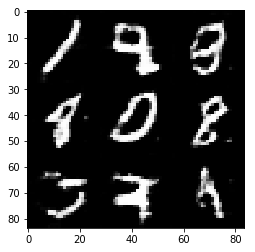

Epoch: 1/2, Batch: 1610/1875 Discriminator Loss: 1.7547 Generator Loss: 0.3230
Epoch: 1/2, Batch: 1620/1875 Discriminator Loss: 1.8009 Generator Loss: 0.3171
Epoch: 1/2, Batch: 1630/1875 Discriminator Loss: 1.4861 Generator Loss: 0.5980
Epoch: 1/2, Batch: 1640/1875 Discriminator Loss: 1.6009 Generator Loss: 0.4142
Epoch: 1/2, Batch: 1650/1875 Discriminator Loss: 1.2253 Generator Loss: 1.9131
Epoch: 1/2, Batch: 1660/1875 Discriminator Loss: 1.0061 Generator Loss: 1.0549
Epoch: 1/2, Batch: 1670/1875 Discriminator Loss: 1.3607 Generator Loss: 0.6633
Epoch: 1/2, Batch: 1680/1875 Discriminator Loss: 1.9704 Generator Loss: 0.2737
Epoch: 1/2, Batch: 1690/1875 Discriminator Loss: 1.8081 Generator Loss: 0.3280
Epoch: 1/2, Batch: 1700/1875 Discriminator Loss: 1.9451 Generator Loss: 0.2785


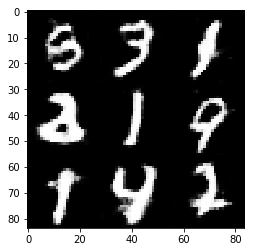

Epoch: 1/2, Batch: 1710/1875 Discriminator Loss: 1.0400 Generator Loss: 1.0285
Epoch: 1/2, Batch: 1720/1875 Discriminator Loss: 1.4007 Generator Loss: 0.5521
Epoch: 1/2, Batch: 1730/1875 Discriminator Loss: 1.7642 Generator Loss: 0.3053
Epoch: 1/2, Batch: 1740/1875 Discriminator Loss: 1.3371 Generator Loss: 0.5821
Epoch: 1/2, Batch: 1750/1875 Discriminator Loss: 1.4846 Generator Loss: 0.4352
Epoch: 1/2, Batch: 1760/1875 Discriminator Loss: 1.6952 Generator Loss: 0.3565
Epoch: 1/2, Batch: 1770/1875 Discriminator Loss: 1.9015 Generator Loss: 0.3180
Epoch: 1/2, Batch: 1780/1875 Discriminator Loss: 1.0894 Generator Loss: 0.8791
Epoch: 1/2, Batch: 1790/1875 Discriminator Loss: 1.3496 Generator Loss: 0.6604
Epoch: 1/2, Batch: 1800/1875 Discriminator Loss: 1.9362 Generator Loss: 0.2799


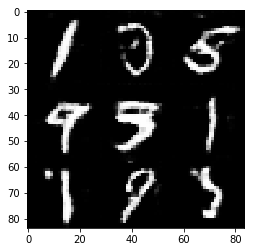

Epoch: 1/2, Batch: 1810/1875 Discriminator Loss: 1.6046 Generator Loss: 0.3740
Epoch: 1/2, Batch: 1820/1875 Discriminator Loss: 1.7830 Generator Loss: 0.3532
Epoch: 1/2, Batch: 1830/1875 Discriminator Loss: 1.0358 Generator Loss: 0.9707
Epoch: 1/2, Batch: 1840/1875 Discriminator Loss: 1.0502 Generator Loss: 0.8493
Epoch: 1/2, Batch: 1850/1875 Discriminator Loss: 2.1599 Generator Loss: 0.2146
Epoch: 1/2, Batch: 1860/1875 Discriminator Loss: 1.5249 Generator Loss: 0.4565
Epoch: 1/2, Batch: 1870/1875 Discriminator Loss: 1.2786 Generator Loss: 0.9433


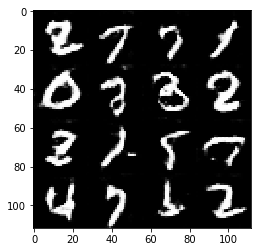

Epoch: 2/2, Batch: 10/1875 Discriminator Loss: 1.4434 Generator Loss: 0.4712
Epoch: 2/2, Batch: 20/1875 Discriminator Loss: 1.1979 Generator Loss: 0.9352
Epoch: 2/2, Batch: 30/1875 Discriminator Loss: 1.9230 Generator Loss: 0.2735
Epoch: 2/2, Batch: 40/1875 Discriminator Loss: 1.7111 Generator Loss: 0.3490
Epoch: 2/2, Batch: 50/1875 Discriminator Loss: 1.2061 Generator Loss: 0.8870
Epoch: 2/2, Batch: 60/1875 Discriminator Loss: 1.3483 Generator Loss: 0.7787
Epoch: 2/2, Batch: 70/1875 Discriminator Loss: 1.7278 Generator Loss: 0.3379
Epoch: 2/2, Batch: 80/1875 Discriminator Loss: 2.6980 Generator Loss: 0.1215
Epoch: 2/2, Batch: 90/1875 Discriminator Loss: 0.9272 Generator Loss: 0.9539
Epoch: 2/2, Batch: 100/1875 Discriminator Loss: 1.5161 Generator Loss: 0.4331


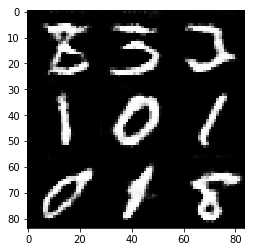

Epoch: 2/2, Batch: 110/1875 Discriminator Loss: 2.0892 Generator Loss: 0.2286
Epoch: 2/2, Batch: 120/1875 Discriminator Loss: 1.3577 Generator Loss: 0.5212
Epoch: 2/2, Batch: 130/1875 Discriminator Loss: 2.1485 Generator Loss: 0.2249
Epoch: 2/2, Batch: 140/1875 Discriminator Loss: 1.5391 Generator Loss: 0.4552
Epoch: 2/2, Batch: 150/1875 Discriminator Loss: 2.8061 Generator Loss: 0.1202
Epoch: 2/2, Batch: 160/1875 Discriminator Loss: 1.5922 Generator Loss: 0.4113
Epoch: 2/2, Batch: 170/1875 Discriminator Loss: 1.2799 Generator Loss: 0.6567
Epoch: 2/2, Batch: 180/1875 Discriminator Loss: 1.3627 Generator Loss: 0.4996
Epoch: 2/2, Batch: 190/1875 Discriminator Loss: 1.8852 Generator Loss: 0.3113
Epoch: 2/2, Batch: 200/1875 Discriminator Loss: 1.2383 Generator Loss: 1.2094


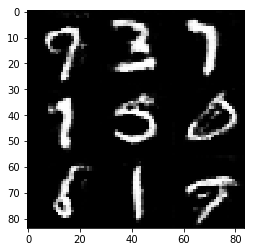

Epoch: 2/2, Batch: 210/1875 Discriminator Loss: 1.4413 Generator Loss: 0.5060
Epoch: 2/2, Batch: 220/1875 Discriminator Loss: 1.1659 Generator Loss: 0.7133
Epoch: 2/2, Batch: 230/1875 Discriminator Loss: 1.6331 Generator Loss: 0.3728
Epoch: 2/2, Batch: 240/1875 Discriminator Loss: 1.2126 Generator Loss: 0.7494
Epoch: 2/2, Batch: 250/1875 Discriminator Loss: 2.0534 Generator Loss: 0.2374
Epoch: 2/2, Batch: 260/1875 Discriminator Loss: 1.3786 Generator Loss: 0.5960
Epoch: 2/2, Batch: 270/1875 Discriminator Loss: 1.5118 Generator Loss: 0.4710
Epoch: 2/2, Batch: 280/1875 Discriminator Loss: 1.0298 Generator Loss: 0.9333
Epoch: 2/2, Batch: 290/1875 Discriminator Loss: 1.5895 Generator Loss: 0.4314
Epoch: 2/2, Batch: 300/1875 Discriminator Loss: 1.3197 Generator Loss: 0.6007


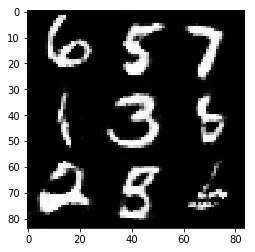

Epoch: 2/2, Batch: 310/1875 Discriminator Loss: 1.3428 Generator Loss: 0.5621
Epoch: 2/2, Batch: 320/1875 Discriminator Loss: 1.4671 Generator Loss: 0.6657
Epoch: 2/2, Batch: 330/1875 Discriminator Loss: 1.5380 Generator Loss: 0.4764
Epoch: 2/2, Batch: 340/1875 Discriminator Loss: 1.4083 Generator Loss: 0.6678
Epoch: 2/2, Batch: 350/1875 Discriminator Loss: 1.2379 Generator Loss: 0.6548
Epoch: 2/2, Batch: 360/1875 Discriminator Loss: 3.0788 Generator Loss: 0.0983
Epoch: 2/2, Batch: 370/1875 Discriminator Loss: 1.9307 Generator Loss: 0.2927
Epoch: 2/2, Batch: 380/1875 Discriminator Loss: 1.2331 Generator Loss: 0.6804
Epoch: 2/2, Batch: 390/1875 Discriminator Loss: 2.2367 Generator Loss: 0.2210
Epoch: 2/2, Batch: 400/1875 Discriminator Loss: 1.7231 Generator Loss: 0.3441


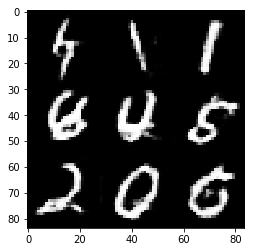

Epoch: 2/2, Batch: 410/1875 Discriminator Loss: 1.8131 Generator Loss: 0.3872
Epoch: 2/2, Batch: 420/1875 Discriminator Loss: 1.1028 Generator Loss: 0.9857
Epoch: 2/2, Batch: 430/1875 Discriminator Loss: 1.5732 Generator Loss: 0.4163
Epoch: 2/2, Batch: 440/1875 Discriminator Loss: 1.2204 Generator Loss: 0.7139
Epoch: 2/2, Batch: 450/1875 Discriminator Loss: 1.7372 Generator Loss: 0.3477
Epoch: 2/2, Batch: 460/1875 Discriminator Loss: 1.6521 Generator Loss: 0.3780
Epoch: 2/2, Batch: 470/1875 Discriminator Loss: 1.3206 Generator Loss: 0.5281
Epoch: 2/2, Batch: 480/1875 Discriminator Loss: 1.1682 Generator Loss: 0.7046
Epoch: 2/2, Batch: 490/1875 Discriminator Loss: 1.3483 Generator Loss: 0.5418
Epoch: 2/2, Batch: 500/1875 Discriminator Loss: 1.3860 Generator Loss: 1.1159


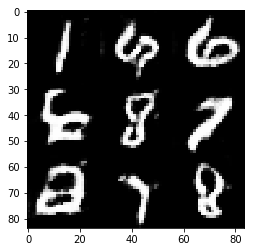

Epoch: 2/2, Batch: 510/1875 Discriminator Loss: 1.8364 Generator Loss: 0.2982
Epoch: 2/2, Batch: 520/1875 Discriminator Loss: 1.8675 Generator Loss: 0.3050
Epoch: 2/2, Batch: 530/1875 Discriminator Loss: 1.8492 Generator Loss: 0.2872
Epoch: 2/2, Batch: 540/1875 Discriminator Loss: 1.7021 Generator Loss: 0.3519
Epoch: 2/2, Batch: 550/1875 Discriminator Loss: 1.4020 Generator Loss: 0.7295
Epoch: 2/2, Batch: 560/1875 Discriminator Loss: 1.5946 Generator Loss: 0.4590
Epoch: 2/2, Batch: 570/1875 Discriminator Loss: 1.4615 Generator Loss: 0.5422
Epoch: 2/2, Batch: 580/1875 Discriminator Loss: 1.0363 Generator Loss: 1.3307
Epoch: 2/2, Batch: 590/1875 Discriminator Loss: 1.5170 Generator Loss: 0.4101
Epoch: 2/2, Batch: 600/1875 Discriminator Loss: 1.5259 Generator Loss: 0.4714


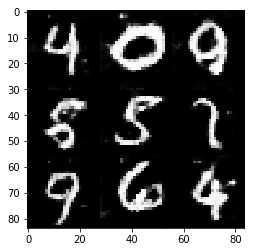

Epoch: 2/2, Batch: 610/1875 Discriminator Loss: 1.1967 Generator Loss: 0.7603
Epoch: 2/2, Batch: 620/1875 Discriminator Loss: 1.9965 Generator Loss: 0.2603
Epoch: 2/2, Batch: 630/1875 Discriminator Loss: 1.3555 Generator Loss: 0.8666
Epoch: 2/2, Batch: 640/1875 Discriminator Loss: 1.3746 Generator Loss: 0.5878
Epoch: 2/2, Batch: 650/1875 Discriminator Loss: 1.5069 Generator Loss: 0.5564
Epoch: 2/2, Batch: 660/1875 Discriminator Loss: 1.8227 Generator Loss: 0.3112
Epoch: 2/2, Batch: 670/1875 Discriminator Loss: 1.7230 Generator Loss: 0.3663
Epoch: 2/2, Batch: 680/1875 Discriminator Loss: 2.8606 Generator Loss: 0.1145
Epoch: 2/2, Batch: 690/1875 Discriminator Loss: 1.8937 Generator Loss: 0.2927
Epoch: 2/2, Batch: 700/1875 Discriminator Loss: 1.2257 Generator Loss: 0.8952


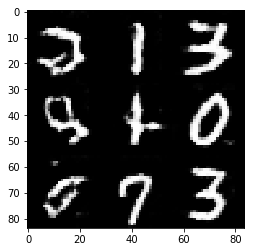

Epoch: 2/2, Batch: 710/1875 Discriminator Loss: 1.8970 Generator Loss: 0.3081
Epoch: 2/2, Batch: 720/1875 Discriminator Loss: 1.7340 Generator Loss: 0.3684
Epoch: 2/2, Batch: 730/1875 Discriminator Loss: 1.7787 Generator Loss: 0.3336
Epoch: 2/2, Batch: 740/1875 Discriminator Loss: 1.2164 Generator Loss: 0.6593
Epoch: 2/2, Batch: 750/1875 Discriminator Loss: 2.1361 Generator Loss: 2.5929
Epoch: 2/2, Batch: 760/1875 Discriminator Loss: 1.1355 Generator Loss: 0.7586
Epoch: 2/2, Batch: 770/1875 Discriminator Loss: 1.2575 Generator Loss: 0.6439
Epoch: 2/2, Batch: 780/1875 Discriminator Loss: 1.2713 Generator Loss: 0.6856
Epoch: 2/2, Batch: 790/1875 Discriminator Loss: 1.7704 Generator Loss: 0.3604
Epoch: 2/2, Batch: 800/1875 Discriminator Loss: 1.2924 Generator Loss: 0.6407


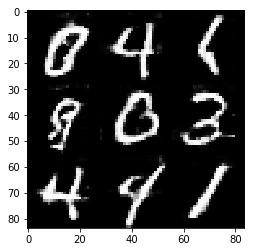

Epoch: 2/2, Batch: 810/1875 Discriminator Loss: 1.9004 Generator Loss: 0.3212
Epoch: 2/2, Batch: 820/1875 Discriminator Loss: 0.9618 Generator Loss: 1.1561
Epoch: 2/2, Batch: 830/1875 Discriminator Loss: 1.6968 Generator Loss: 0.3322
Epoch: 2/2, Batch: 840/1875 Discriminator Loss: 1.4069 Generator Loss: 0.6192
Epoch: 2/2, Batch: 850/1875 Discriminator Loss: 2.1298 Generator Loss: 0.2247
Epoch: 2/2, Batch: 860/1875 Discriminator Loss: 1.4882 Generator Loss: 0.4566
Epoch: 2/2, Batch: 870/1875 Discriminator Loss: 1.4891 Generator Loss: 0.4759
Epoch: 2/2, Batch: 880/1875 Discriminator Loss: 1.9494 Generator Loss: 0.3471
Epoch: 2/2, Batch: 890/1875 Discriminator Loss: 2.4831 Generator Loss: 0.1744
Epoch: 2/2, Batch: 900/1875 Discriminator Loss: 1.2047 Generator Loss: 0.6563


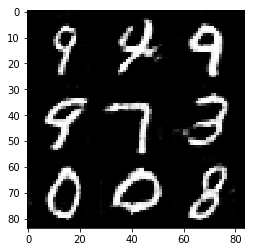

Epoch: 2/2, Batch: 910/1875 Discriminator Loss: 1.4602 Generator Loss: 0.6396
Epoch: 2/2, Batch: 920/1875 Discriminator Loss: 0.9153 Generator Loss: 1.0549
Epoch: 2/2, Batch: 930/1875 Discriminator Loss: 2.2689 Generator Loss: 0.2155
Epoch: 2/2, Batch: 940/1875 Discriminator Loss: 1.6351 Generator Loss: 0.4113
Epoch: 2/2, Batch: 950/1875 Discriminator Loss: 1.3349 Generator Loss: 0.6043
Epoch: 2/2, Batch: 960/1875 Discriminator Loss: 1.5933 Generator Loss: 0.4106
Epoch: 2/2, Batch: 970/1875 Discriminator Loss: 1.1724 Generator Loss: 0.7522
Epoch: 2/2, Batch: 980/1875 Discriminator Loss: 1.1945 Generator Loss: 0.6636
Epoch: 2/2, Batch: 990/1875 Discriminator Loss: 1.1053 Generator Loss: 1.1476
Epoch: 2/2, Batch: 1000/1875 Discriminator Loss: 1.7667 Generator Loss: 0.3527


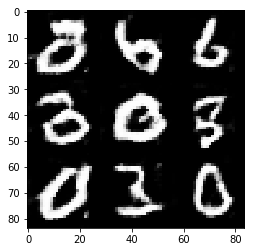

Epoch: 2/2, Batch: 1010/1875 Discriminator Loss: 1.2397 Generator Loss: 0.6954
Epoch: 2/2, Batch: 1020/1875 Discriminator Loss: 1.9969 Generator Loss: 0.2948
Epoch: 2/2, Batch: 1030/1875 Discriminator Loss: 1.3926 Generator Loss: 0.5229
Epoch: 2/2, Batch: 1040/1875 Discriminator Loss: 3.1553 Generator Loss: 0.0861
Epoch: 2/2, Batch: 1050/1875 Discriminator Loss: 1.3667 Generator Loss: 0.5376
Epoch: 2/2, Batch: 1060/1875 Discriminator Loss: 1.4224 Generator Loss: 0.5235
Epoch: 2/2, Batch: 1070/1875 Discriminator Loss: 0.7829 Generator Loss: 1.2341
Epoch: 2/2, Batch: 1080/1875 Discriminator Loss: 1.4161 Generator Loss: 0.5226
Epoch: 2/2, Batch: 1090/1875 Discriminator Loss: 1.1511 Generator Loss: 0.6625
Epoch: 2/2, Batch: 1100/1875 Discriminator Loss: 1.4107 Generator Loss: 1.4011


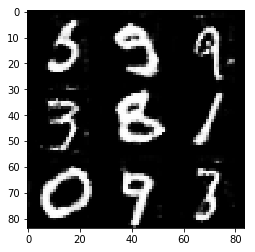

Epoch: 2/2, Batch: 1110/1875 Discriminator Loss: 1.0858 Generator Loss: 1.1614
Epoch: 2/2, Batch: 1120/1875 Discriminator Loss: 1.0795 Generator Loss: 0.8289
Epoch: 2/2, Batch: 1130/1875 Discriminator Loss: 2.1468 Generator Loss: 0.2259
Epoch: 2/2, Batch: 1140/1875 Discriminator Loss: 1.2242 Generator Loss: 0.6352
Epoch: 2/2, Batch: 1150/1875 Discriminator Loss: 1.4353 Generator Loss: 0.4615
Epoch: 2/2, Batch: 1160/1875 Discriminator Loss: 1.5277 Generator Loss: 0.4258
Epoch: 2/2, Batch: 1170/1875 Discriminator Loss: 1.7231 Generator Loss: 0.3338
Epoch: 2/2, Batch: 1180/1875 Discriminator Loss: 1.5055 Generator Loss: 0.4487
Epoch: 2/2, Batch: 1190/1875 Discriminator Loss: 1.9529 Generator Loss: 0.2614
Epoch: 2/2, Batch: 1200/1875 Discriminator Loss: 2.0291 Generator Loss: 0.2521


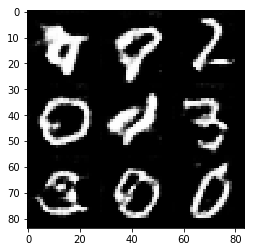

Epoch: 2/2, Batch: 1210/1875 Discriminator Loss: 1.7975 Generator Loss: 0.4295
Epoch: 2/2, Batch: 1220/1875 Discriminator Loss: 2.5219 Generator Loss: 0.1842
Epoch: 2/2, Batch: 1230/1875 Discriminator Loss: 1.4305 Generator Loss: 0.5052
Epoch: 2/2, Batch: 1240/1875 Discriminator Loss: 1.5868 Generator Loss: 0.4426
Epoch: 2/2, Batch: 1250/1875 Discriminator Loss: 2.0221 Generator Loss: 0.2929
Epoch: 2/2, Batch: 1260/1875 Discriminator Loss: 1.6069 Generator Loss: 0.3830
Epoch: 2/2, Batch: 1270/1875 Discriminator Loss: 1.8760 Generator Loss: 0.2946
Epoch: 2/2, Batch: 1280/1875 Discriminator Loss: 1.5434 Generator Loss: 0.4255
Epoch: 2/2, Batch: 1290/1875 Discriminator Loss: 1.5651 Generator Loss: 1.7426
Epoch: 2/2, Batch: 1300/1875 Discriminator Loss: 1.1704 Generator Loss: 0.8137


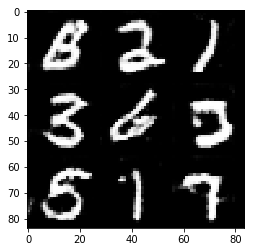

Epoch: 2/2, Batch: 1310/1875 Discriminator Loss: 1.8658 Generator Loss: 0.4216
Epoch: 2/2, Batch: 1320/1875 Discriminator Loss: 1.1365 Generator Loss: 1.3072
Epoch: 2/2, Batch: 1330/1875 Discriminator Loss: 1.3284 Generator Loss: 0.5733
Epoch: 2/2, Batch: 1340/1875 Discriminator Loss: 1.5547 Generator Loss: 0.8778
Epoch: 2/2, Batch: 1350/1875 Discriminator Loss: 1.5127 Generator Loss: 0.5321
Epoch: 2/2, Batch: 1360/1875 Discriminator Loss: 1.3823 Generator Loss: 0.5442
Epoch: 2/2, Batch: 1370/1875 Discriminator Loss: 1.8460 Generator Loss: 0.3387
Epoch: 2/2, Batch: 1380/1875 Discriminator Loss: 1.7543 Generator Loss: 0.3848
Epoch: 2/2, Batch: 1390/1875 Discriminator Loss: 2.0056 Generator Loss: 0.2750
Epoch: 2/2, Batch: 1400/1875 Discriminator Loss: 2.1187 Generator Loss: 0.2342


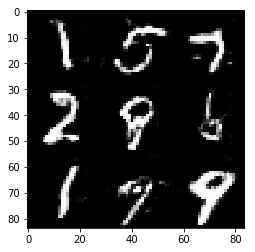

Epoch: 2/2, Batch: 1410/1875 Discriminator Loss: 2.0449 Generator Loss: 0.2730
Epoch: 2/2, Batch: 1420/1875 Discriminator Loss: 1.3645 Generator Loss: 0.5183
Epoch: 2/2, Batch: 1430/1875 Discriminator Loss: 1.1676 Generator Loss: 0.9219
Epoch: 2/2, Batch: 1440/1875 Discriminator Loss: 2.0626 Generator Loss: 0.3031
Epoch: 2/2, Batch: 1450/1875 Discriminator Loss: 1.0047 Generator Loss: 0.8778
Epoch: 2/2, Batch: 1460/1875 Discriminator Loss: 1.1753 Generator Loss: 0.6680
Epoch: 2/2, Batch: 1470/1875 Discriminator Loss: 1.4576 Generator Loss: 0.5131
Epoch: 2/2, Batch: 1480/1875 Discriminator Loss: 1.3191 Generator Loss: 0.8301
Epoch: 2/2, Batch: 1490/1875 Discriminator Loss: 0.9271 Generator Loss: 1.5375
Epoch: 2/2, Batch: 1500/1875 Discriminator Loss: 2.3070 Generator Loss: 0.2074


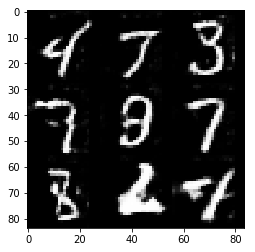

Epoch: 2/2, Batch: 1510/1875 Discriminator Loss: 1.9301 Generator Loss: 0.3057
Epoch: 2/2, Batch: 1520/1875 Discriminator Loss: 1.5363 Generator Loss: 0.4820
Epoch: 2/2, Batch: 1530/1875 Discriminator Loss: 1.8518 Generator Loss: 0.3114
Epoch: 2/2, Batch: 1540/1875 Discriminator Loss: 1.1602 Generator Loss: 0.6939
Epoch: 2/2, Batch: 1550/1875 Discriminator Loss: 1.5213 Generator Loss: 0.4867
Epoch: 2/2, Batch: 1560/1875 Discriminator Loss: 1.9091 Generator Loss: 0.3197
Epoch: 2/2, Batch: 1570/1875 Discriminator Loss: 1.9021 Generator Loss: 0.2926
Epoch: 2/2, Batch: 1580/1875 Discriminator Loss: 1.8416 Generator Loss: 0.3028
Epoch: 2/2, Batch: 1590/1875 Discriminator Loss: 1.7161 Generator Loss: 2.2623
Epoch: 2/2, Batch: 1600/1875 Discriminator Loss: 1.4454 Generator Loss: 0.4891


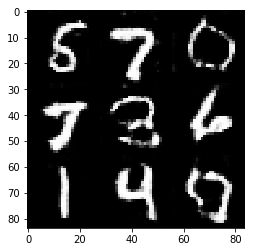

Epoch: 2/2, Batch: 1610/1875 Discriminator Loss: 1.5357 Generator Loss: 0.4426
Epoch: 2/2, Batch: 1620/1875 Discriminator Loss: 1.1765 Generator Loss: 0.9356
Epoch: 2/2, Batch: 1630/1875 Discriminator Loss: 1.6204 Generator Loss: 0.5378
Epoch: 2/2, Batch: 1640/1875 Discriminator Loss: 1.4522 Generator Loss: 0.4727
Epoch: 2/2, Batch: 1650/1875 Discriminator Loss: 1.0128 Generator Loss: 1.1192
Epoch: 2/2, Batch: 1660/1875 Discriminator Loss: 1.2036 Generator Loss: 0.5948
Epoch: 2/2, Batch: 1670/1875 Discriminator Loss: 1.9348 Generator Loss: 0.2683
Epoch: 2/2, Batch: 1680/1875 Discriminator Loss: 2.4112 Generator Loss: 0.1514
Epoch: 2/2, Batch: 1690/1875 Discriminator Loss: 1.7343 Generator Loss: 0.3429
Epoch: 2/2, Batch: 1700/1875 Discriminator Loss: 1.7308 Generator Loss: 1.5584


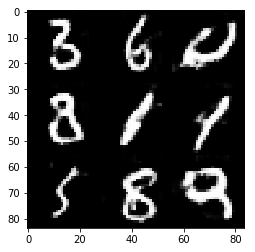

Epoch: 2/2, Batch: 1710/1875 Discriminator Loss: 1.1787 Generator Loss: 0.8847
Epoch: 2/2, Batch: 1720/1875 Discriminator Loss: 1.6620 Generator Loss: 0.3805
Epoch: 2/2, Batch: 1730/1875 Discriminator Loss: 1.6634 Generator Loss: 0.3707
Epoch: 2/2, Batch: 1740/1875 Discriminator Loss: 1.5373 Generator Loss: 0.5195
Epoch: 2/2, Batch: 1750/1875 Discriminator Loss: 1.2271 Generator Loss: 0.6631
Epoch: 2/2, Batch: 1760/1875 Discriminator Loss: 1.0900 Generator Loss: 0.7403
Epoch: 2/2, Batch: 1770/1875 Discriminator Loss: 1.3376 Generator Loss: 0.6307
Epoch: 2/2, Batch: 1780/1875 Discriminator Loss: 2.5586 Generator Loss: 0.1460
Epoch: 2/2, Batch: 1790/1875 Discriminator Loss: 1.7183 Generator Loss: 0.3410
Epoch: 2/2, Batch: 1800/1875 Discriminator Loss: 2.2339 Generator Loss: 0.1997


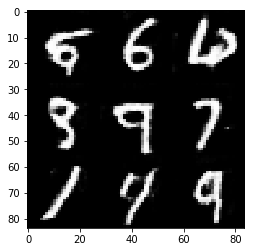

Epoch: 2/2, Batch: 1810/1875 Discriminator Loss: 1.6855 Generator Loss: 0.3477
Epoch: 2/2, Batch: 1820/1875 Discriminator Loss: 2.3516 Generator Loss: 0.1945
Epoch: 2/2, Batch: 1830/1875 Discriminator Loss: 1.2453 Generator Loss: 0.7452
Epoch: 2/2, Batch: 1840/1875 Discriminator Loss: 1.5307 Generator Loss: 0.4160
Epoch: 2/2, Batch: 1850/1875 Discriminator Loss: 1.7600 Generator Loss: 0.3415
Epoch: 2/2, Batch: 1860/1875 Discriminator Loss: 1.1981 Generator Loss: 0.6836
Epoch: 2/2, Batch: 1870/1875 Discriminator Loss: 0.9037 Generator Loss: 1.0389


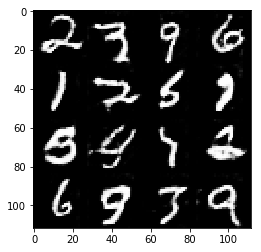

In [25]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1, Batch: 10/6331 Discriminator Loss: 6.5115 Generator Loss: 0.0049
Epoch: 1/1, Batch: 20/6331 Discriminator Loss: 3.3562 Generator Loss: 0.0677
Epoch: 1/1, Batch: 30/6331 Discriminator Loss: 2.3894 Generator Loss: 0.5822
Epoch: 1/1, Batch: 40/6331 Discriminator Loss: 1.9158 Generator Loss: 0.6865
Epoch: 1/1, Batch: 50/6331 Discriminator Loss: 1.7862 Generator Loss: 2.1573
Epoch: 1/1, Batch: 60/6331 Discriminator Loss: 1.8526 Generator Loss: 1.1507
Epoch: 1/1, Batch: 70/6331 Discriminator Loss: 1.8870 Generator Loss: 0.4456
Epoch: 1/1, Batch: 80/6331 Discriminator Loss: 1.7687 Generator Loss: 0.7862
Epoch: 1/1, Batch: 90/6331 Discriminator Loss: 1.6691 Generator Loss: 1.2261
Epoch: 1/1, Batch: 100/6331 Discriminator Loss: 1.6748 Generator Loss: 0.8608


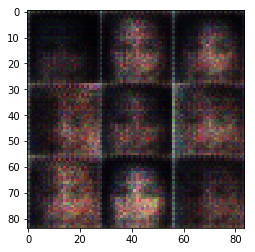

Epoch: 1/1, Batch: 110/6331 Discriminator Loss: 1.6951 Generator Loss: 0.4298
Epoch: 1/1, Batch: 120/6331 Discriminator Loss: 2.1588 Generator Loss: 0.2387
Epoch: 1/1, Batch: 130/6331 Discriminator Loss: 1.4837 Generator Loss: 0.7791
Epoch: 1/1, Batch: 140/6331 Discriminator Loss: 1.3770 Generator Loss: 0.7101
Epoch: 1/1, Batch: 150/6331 Discriminator Loss: 1.5521 Generator Loss: 0.5380
Epoch: 1/1, Batch: 160/6331 Discriminator Loss: 1.7167 Generator Loss: 0.4782
Epoch: 1/1, Batch: 170/6331 Discriminator Loss: 1.6079 Generator Loss: 0.5733
Epoch: 1/1, Batch: 180/6331 Discriminator Loss: 1.5958 Generator Loss: 0.5037
Epoch: 1/1, Batch: 190/6331 Discriminator Loss: 1.4996 Generator Loss: 0.9391
Epoch: 1/1, Batch: 200/6331 Discriminator Loss: 1.5864 Generator Loss: 0.5881


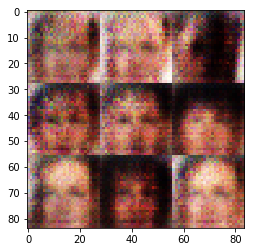

Epoch: 1/1, Batch: 210/6331 Discriminator Loss: 1.5510 Generator Loss: 0.5724
Epoch: 1/1, Batch: 220/6331 Discriminator Loss: 1.6337 Generator Loss: 0.5134
Epoch: 1/1, Batch: 230/6331 Discriminator Loss: 1.4858 Generator Loss: 0.7365
Epoch: 1/1, Batch: 240/6331 Discriminator Loss: 1.4970 Generator Loss: 0.7776
Epoch: 1/1, Batch: 250/6331 Discriminator Loss: 1.4544 Generator Loss: 0.8241
Epoch: 1/1, Batch: 260/6331 Discriminator Loss: 1.3824 Generator Loss: 0.6797
Epoch: 1/1, Batch: 270/6331 Discriminator Loss: 1.4965 Generator Loss: 0.6385
Epoch: 1/1, Batch: 280/6331 Discriminator Loss: 1.4545 Generator Loss: 0.6612
Epoch: 1/1, Batch: 290/6331 Discriminator Loss: 1.3546 Generator Loss: 0.6981
Epoch: 1/1, Batch: 300/6331 Discriminator Loss: 1.3217 Generator Loss: 0.7899


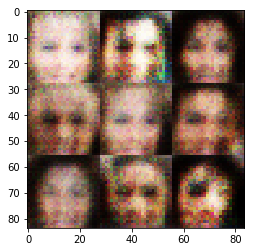

Epoch: 1/1, Batch: 310/6331 Discriminator Loss: 1.5606 Generator Loss: 0.6964
Epoch: 1/1, Batch: 320/6331 Discriminator Loss: 1.3915 Generator Loss: 0.7113
Epoch: 1/1, Batch: 330/6331 Discriminator Loss: 1.5757 Generator Loss: 0.5190
Epoch: 1/1, Batch: 340/6331 Discriminator Loss: 1.5095 Generator Loss: 0.7007
Epoch: 1/1, Batch: 350/6331 Discriminator Loss: 1.4516 Generator Loss: 0.7390
Epoch: 1/1, Batch: 360/6331 Discriminator Loss: 1.4101 Generator Loss: 0.8237
Epoch: 1/1, Batch: 370/6331 Discriminator Loss: 1.4653 Generator Loss: 0.8682
Epoch: 1/1, Batch: 380/6331 Discriminator Loss: 1.4290 Generator Loss: 0.7096
Epoch: 1/1, Batch: 390/6331 Discriminator Loss: 1.4145 Generator Loss: 0.8346
Epoch: 1/1, Batch: 400/6331 Discriminator Loss: 1.4319 Generator Loss: 0.6529


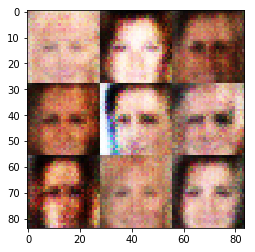

Epoch: 1/1, Batch: 410/6331 Discriminator Loss: 1.4468 Generator Loss: 0.7354
Epoch: 1/1, Batch: 420/6331 Discriminator Loss: 1.4319 Generator Loss: 0.8359
Epoch: 1/1, Batch: 430/6331 Discriminator Loss: 1.4861 Generator Loss: 0.5846
Epoch: 1/1, Batch: 440/6331 Discriminator Loss: 1.4205 Generator Loss: 0.6166
Epoch: 1/1, Batch: 450/6331 Discriminator Loss: 1.4503 Generator Loss: 0.6761
Epoch: 1/1, Batch: 460/6331 Discriminator Loss: 1.4589 Generator Loss: 0.6291
Epoch: 1/1, Batch: 470/6331 Discriminator Loss: 1.4000 Generator Loss: 0.7426
Epoch: 1/1, Batch: 480/6331 Discriminator Loss: 1.3784 Generator Loss: 0.8240
Epoch: 1/1, Batch: 490/6331 Discriminator Loss: 1.4050 Generator Loss: 0.7644
Epoch: 1/1, Batch: 500/6331 Discriminator Loss: 1.4048 Generator Loss: 0.7048


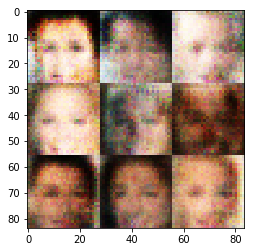

Epoch: 1/1, Batch: 510/6331 Discriminator Loss: 1.4705 Generator Loss: 0.6371
Epoch: 1/1, Batch: 520/6331 Discriminator Loss: 1.4336 Generator Loss: 0.8273
Epoch: 1/1, Batch: 530/6331 Discriminator Loss: 1.4180 Generator Loss: 0.6998
Epoch: 1/1, Batch: 540/6331 Discriminator Loss: 1.3402 Generator Loss: 0.7446
Epoch: 1/1, Batch: 550/6331 Discriminator Loss: 1.4118 Generator Loss: 0.7305
Epoch: 1/1, Batch: 560/6331 Discriminator Loss: 1.4225 Generator Loss: 0.7221
Epoch: 1/1, Batch: 570/6331 Discriminator Loss: 1.3920 Generator Loss: 0.6674
Epoch: 1/1, Batch: 580/6331 Discriminator Loss: 1.3694 Generator Loss: 0.7587
Epoch: 1/1, Batch: 590/6331 Discriminator Loss: 1.4205 Generator Loss: 0.6993
Epoch: 1/1, Batch: 600/6331 Discriminator Loss: 1.3940 Generator Loss: 0.8107


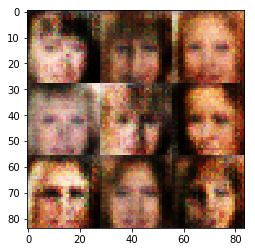

Epoch: 1/1, Batch: 610/6331 Discriminator Loss: 1.4321 Generator Loss: 0.6562
Epoch: 1/1, Batch: 620/6331 Discriminator Loss: 1.4015 Generator Loss: 0.8148
Epoch: 1/1, Batch: 630/6331 Discriminator Loss: 1.4093 Generator Loss: 0.8278
Epoch: 1/1, Batch: 640/6331 Discriminator Loss: 1.4043 Generator Loss: 0.8058
Epoch: 1/1, Batch: 650/6331 Discriminator Loss: 1.4024 Generator Loss: 0.7196
Epoch: 1/1, Batch: 660/6331 Discriminator Loss: 1.4314 Generator Loss: 0.7303
Epoch: 1/1, Batch: 670/6331 Discriminator Loss: 1.4138 Generator Loss: 0.7342
Epoch: 1/1, Batch: 680/6331 Discriminator Loss: 1.4723 Generator Loss: 0.5809
Epoch: 1/1, Batch: 690/6331 Discriminator Loss: 1.4259 Generator Loss: 0.7670
Epoch: 1/1, Batch: 700/6331 Discriminator Loss: 1.3751 Generator Loss: 0.7161


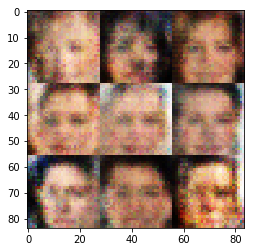

Epoch: 1/1, Batch: 710/6331 Discriminator Loss: 1.4128 Generator Loss: 0.7703
Epoch: 1/1, Batch: 720/6331 Discriminator Loss: 1.4004 Generator Loss: 0.6800
Epoch: 1/1, Batch: 730/6331 Discriminator Loss: 1.4311 Generator Loss: 0.8928
Epoch: 1/1, Batch: 740/6331 Discriminator Loss: 1.4243 Generator Loss: 0.7900
Epoch: 1/1, Batch: 750/6331 Discriminator Loss: 1.4145 Generator Loss: 0.7775
Epoch: 1/1, Batch: 760/6331 Discriminator Loss: 1.3722 Generator Loss: 0.8404
Epoch: 1/1, Batch: 770/6331 Discriminator Loss: 1.3959 Generator Loss: 0.8065
Epoch: 1/1, Batch: 780/6331 Discriminator Loss: 1.4001 Generator Loss: 0.7399
Epoch: 1/1, Batch: 790/6331 Discriminator Loss: 1.4151 Generator Loss: 0.7526
Epoch: 1/1, Batch: 800/6331 Discriminator Loss: 1.3921 Generator Loss: 0.7641


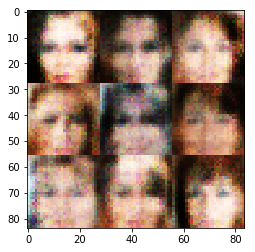

Epoch: 1/1, Batch: 810/6331 Discriminator Loss: 1.4082 Generator Loss: 0.7775
Epoch: 1/1, Batch: 820/6331 Discriminator Loss: 1.4541 Generator Loss: 0.9066
Epoch: 1/1, Batch: 830/6331 Discriminator Loss: 1.4228 Generator Loss: 0.8336
Epoch: 1/1, Batch: 840/6331 Discriminator Loss: 1.4079 Generator Loss: 0.7562
Epoch: 1/1, Batch: 850/6331 Discriminator Loss: 1.3748 Generator Loss: 0.7192
Epoch: 1/1, Batch: 860/6331 Discriminator Loss: 1.4479 Generator Loss: 0.6575
Epoch: 1/1, Batch: 870/6331 Discriminator Loss: 1.4483 Generator Loss: 0.7088
Epoch: 1/1, Batch: 880/6331 Discriminator Loss: 1.4433 Generator Loss: 0.6590
Epoch: 1/1, Batch: 890/6331 Discriminator Loss: 1.3876 Generator Loss: 0.8882
Epoch: 1/1, Batch: 900/6331 Discriminator Loss: 1.3538 Generator Loss: 0.7785


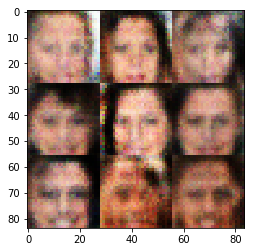

Epoch: 1/1, Batch: 910/6331 Discriminator Loss: 1.4625 Generator Loss: 0.8783
Epoch: 1/1, Batch: 920/6331 Discriminator Loss: 1.4132 Generator Loss: 0.7705
Epoch: 1/1, Batch: 930/6331 Discriminator Loss: 1.3654 Generator Loss: 0.7018
Epoch: 1/1, Batch: 940/6331 Discriminator Loss: 1.4059 Generator Loss: 0.7728
Epoch: 1/1, Batch: 950/6331 Discriminator Loss: 1.3769 Generator Loss: 0.8424
Epoch: 1/1, Batch: 960/6331 Discriminator Loss: 1.3882 Generator Loss: 0.7494
Epoch: 1/1, Batch: 970/6331 Discriminator Loss: 1.4355 Generator Loss: 0.9698
Epoch: 1/1, Batch: 980/6331 Discriminator Loss: 1.3836 Generator Loss: 0.7374
Epoch: 1/1, Batch: 990/6331 Discriminator Loss: 1.3959 Generator Loss: 0.7636
Epoch: 1/1, Batch: 1000/6331 Discriminator Loss: 1.4009 Generator Loss: 0.6946


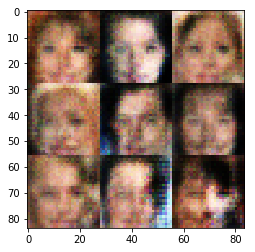

Epoch: 1/1, Batch: 1010/6331 Discriminator Loss: 1.4168 Generator Loss: 0.7259
Epoch: 1/1, Batch: 1020/6331 Discriminator Loss: 1.3932 Generator Loss: 0.6826
Epoch: 1/1, Batch: 1030/6331 Discriminator Loss: 1.3857 Generator Loss: 0.7182
Epoch: 1/1, Batch: 1040/6331 Discriminator Loss: 1.4404 Generator Loss: 0.7366
Epoch: 1/1, Batch: 1050/6331 Discriminator Loss: 1.4284 Generator Loss: 0.7665
Epoch: 1/1, Batch: 1060/6331 Discriminator Loss: 1.4372 Generator Loss: 0.7194
Epoch: 1/1, Batch: 1070/6331 Discriminator Loss: 1.3603 Generator Loss: 0.7481
Epoch: 1/1, Batch: 1080/6331 Discriminator Loss: 1.3977 Generator Loss: 0.7130
Epoch: 1/1, Batch: 1090/6331 Discriminator Loss: 1.4027 Generator Loss: 0.7112
Epoch: 1/1, Batch: 1100/6331 Discriminator Loss: 1.4186 Generator Loss: 0.8049


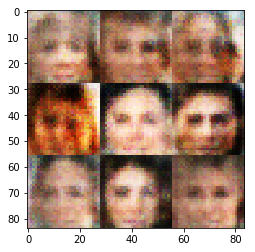

Epoch: 1/1, Batch: 1110/6331 Discriminator Loss: 1.3817 Generator Loss: 0.7102
Epoch: 1/1, Batch: 1120/6331 Discriminator Loss: 1.4046 Generator Loss: 0.6661
Epoch: 1/1, Batch: 1130/6331 Discriminator Loss: 1.4445 Generator Loss: 0.7665
Epoch: 1/1, Batch: 1140/6331 Discriminator Loss: 1.4167 Generator Loss: 0.7855
Epoch: 1/1, Batch: 1150/6331 Discriminator Loss: 1.4154 Generator Loss: 0.7031
Epoch: 1/1, Batch: 1160/6331 Discriminator Loss: 1.4077 Generator Loss: 0.7662
Epoch: 1/1, Batch: 1170/6331 Discriminator Loss: 1.4265 Generator Loss: 0.7278
Epoch: 1/1, Batch: 1180/6331 Discriminator Loss: 1.4261 Generator Loss: 0.7478
Epoch: 1/1, Batch: 1190/6331 Discriminator Loss: 1.4256 Generator Loss: 0.7164
Epoch: 1/1, Batch: 1200/6331 Discriminator Loss: 1.4248 Generator Loss: 0.7237


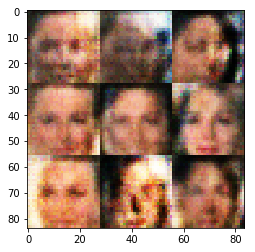

Epoch: 1/1, Batch: 1210/6331 Discriminator Loss: 1.4007 Generator Loss: 0.8159
Epoch: 1/1, Batch: 1220/6331 Discriminator Loss: 1.4021 Generator Loss: 0.7706
Epoch: 1/1, Batch: 1230/6331 Discriminator Loss: 1.3954 Generator Loss: 0.7592
Epoch: 1/1, Batch: 1240/6331 Discriminator Loss: 1.3922 Generator Loss: 0.7674
Epoch: 1/1, Batch: 1250/6331 Discriminator Loss: 1.4042 Generator Loss: 0.7641
Epoch: 1/1, Batch: 1260/6331 Discriminator Loss: 1.3978 Generator Loss: 0.6498
Epoch: 1/1, Batch: 1270/6331 Discriminator Loss: 1.4203 Generator Loss: 0.6852
Epoch: 1/1, Batch: 1280/6331 Discriminator Loss: 1.4137 Generator Loss: 0.9290
Epoch: 1/1, Batch: 1290/6331 Discriminator Loss: 1.3959 Generator Loss: 0.7191
Epoch: 1/1, Batch: 1300/6331 Discriminator Loss: 1.3770 Generator Loss: 0.7732


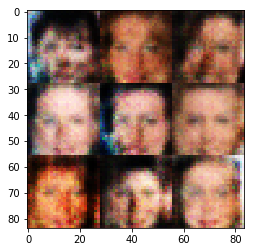

Epoch: 1/1, Batch: 1310/6331 Discriminator Loss: 1.4114 Generator Loss: 0.7481
Epoch: 1/1, Batch: 1320/6331 Discriminator Loss: 1.3969 Generator Loss: 0.8375
Epoch: 1/1, Batch: 1330/6331 Discriminator Loss: 1.3924 Generator Loss: 0.8099
Epoch: 1/1, Batch: 1340/6331 Discriminator Loss: 1.4167 Generator Loss: 0.7061
Epoch: 1/1, Batch: 1350/6331 Discriminator Loss: 1.3793 Generator Loss: 0.8256
Epoch: 1/1, Batch: 1360/6331 Discriminator Loss: 1.4131 Generator Loss: 0.7728
Epoch: 1/1, Batch: 1370/6331 Discriminator Loss: 1.4264 Generator Loss: 0.7499
Epoch: 1/1, Batch: 1380/6331 Discriminator Loss: 1.3919 Generator Loss: 0.6934
Epoch: 1/1, Batch: 1390/6331 Discriminator Loss: 1.3910 Generator Loss: 0.7775
Epoch: 1/1, Batch: 1400/6331 Discriminator Loss: 1.4101 Generator Loss: 0.8913


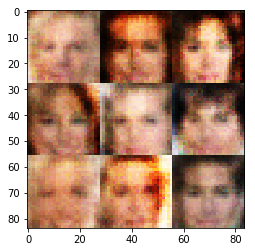

Epoch: 1/1, Batch: 1410/6331 Discriminator Loss: 1.4261 Generator Loss: 0.8106
Epoch: 1/1, Batch: 1420/6331 Discriminator Loss: 1.4164 Generator Loss: 0.7685
Epoch: 1/1, Batch: 1430/6331 Discriminator Loss: 1.4129 Generator Loss: 0.8749
Epoch: 1/1, Batch: 1440/6331 Discriminator Loss: 1.4207 Generator Loss: 0.7809
Epoch: 1/1, Batch: 1450/6331 Discriminator Loss: 1.3720 Generator Loss: 0.7284
Epoch: 1/1, Batch: 1460/6331 Discriminator Loss: 1.3943 Generator Loss: 0.8372
Epoch: 1/1, Batch: 1470/6331 Discriminator Loss: 1.3994 Generator Loss: 0.8402
Epoch: 1/1, Batch: 1480/6331 Discriminator Loss: 1.4155 Generator Loss: 0.7183
Epoch: 1/1, Batch: 1490/6331 Discriminator Loss: 1.4274 Generator Loss: 0.8550
Epoch: 1/1, Batch: 1500/6331 Discriminator Loss: 1.4060 Generator Loss: 0.8098


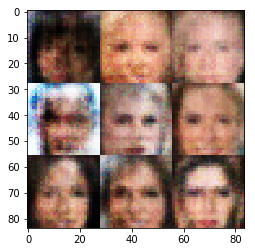

Epoch: 1/1, Batch: 1510/6331 Discriminator Loss: 1.4503 Generator Loss: 0.6073
Epoch: 1/1, Batch: 1520/6331 Discriminator Loss: 1.3882 Generator Loss: 0.8282
Epoch: 1/1, Batch: 1530/6331 Discriminator Loss: 1.4073 Generator Loss: 0.6878
Epoch: 1/1, Batch: 1540/6331 Discriminator Loss: 1.3778 Generator Loss: 0.7413
Epoch: 1/1, Batch: 1550/6331 Discriminator Loss: 1.3990 Generator Loss: 0.7001
Epoch: 1/1, Batch: 1560/6331 Discriminator Loss: 1.3955 Generator Loss: 0.8114
Epoch: 1/1, Batch: 1570/6331 Discriminator Loss: 1.3871 Generator Loss: 0.7504
Epoch: 1/1, Batch: 1580/6331 Discriminator Loss: 1.3833 Generator Loss: 0.7476
Epoch: 1/1, Batch: 1590/6331 Discriminator Loss: 1.4069 Generator Loss: 0.8695
Epoch: 1/1, Batch: 1600/6331 Discriminator Loss: 1.4046 Generator Loss: 0.8635


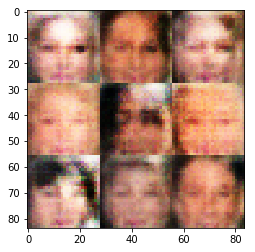

Epoch: 1/1, Batch: 1610/6331 Discriminator Loss: 1.4433 Generator Loss: 0.6880
Epoch: 1/1, Batch: 1620/6331 Discriminator Loss: 1.3834 Generator Loss: 0.8121
Epoch: 1/1, Batch: 1630/6331 Discriminator Loss: 1.4051 Generator Loss: 0.8354
Epoch: 1/1, Batch: 1640/6331 Discriminator Loss: 1.3895 Generator Loss: 0.8032
Epoch: 1/1, Batch: 1650/6331 Discriminator Loss: 1.3608 Generator Loss: 0.7677
Epoch: 1/1, Batch: 1660/6331 Discriminator Loss: 1.3883 Generator Loss: 0.6935
Epoch: 1/1, Batch: 1670/6331 Discriminator Loss: 1.4091 Generator Loss: 0.6903
Epoch: 1/1, Batch: 1680/6331 Discriminator Loss: 1.4261 Generator Loss: 0.9627
Epoch: 1/1, Batch: 1690/6331 Discriminator Loss: 1.3834 Generator Loss: 0.8198
Epoch: 1/1, Batch: 1700/6331 Discriminator Loss: 1.3991 Generator Loss: 0.8177


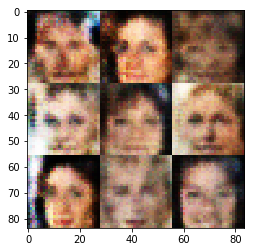

Epoch: 1/1, Batch: 1710/6331 Discriminator Loss: 1.3972 Generator Loss: 0.7352
Epoch: 1/1, Batch: 1720/6331 Discriminator Loss: 1.3994 Generator Loss: 0.7931
Epoch: 1/1, Batch: 1730/6331 Discriminator Loss: 1.4151 Generator Loss: 0.7713
Epoch: 1/1, Batch: 1740/6331 Discriminator Loss: 1.4003 Generator Loss: 0.7401
Epoch: 1/1, Batch: 1750/6331 Discriminator Loss: 1.4282 Generator Loss: 0.8249
Epoch: 1/1, Batch: 1760/6331 Discriminator Loss: 1.4068 Generator Loss: 0.7396
Epoch: 1/1, Batch: 1770/6331 Discriminator Loss: 1.3695 Generator Loss: 0.7791
Epoch: 1/1, Batch: 1780/6331 Discriminator Loss: 1.4251 Generator Loss: 0.7238
Epoch: 1/1, Batch: 1790/6331 Discriminator Loss: 1.3761 Generator Loss: 0.8347
Epoch: 1/1, Batch: 1800/6331 Discriminator Loss: 1.4105 Generator Loss: 0.8070


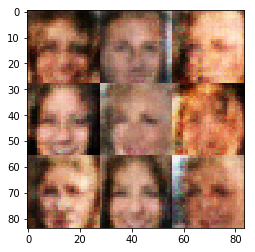

Epoch: 1/1, Batch: 1810/6331 Discriminator Loss: 1.4041 Generator Loss: 0.8045
Epoch: 1/1, Batch: 1820/6331 Discriminator Loss: 1.4027 Generator Loss: 0.8132
Epoch: 1/1, Batch: 1830/6331 Discriminator Loss: 1.4033 Generator Loss: 0.7627
Epoch: 1/1, Batch: 1840/6331 Discriminator Loss: 1.3889 Generator Loss: 0.7067
Epoch: 1/1, Batch: 1850/6331 Discriminator Loss: 1.3944 Generator Loss: 0.7836
Epoch: 1/1, Batch: 1860/6331 Discriminator Loss: 1.4119 Generator Loss: 0.6481
Epoch: 1/1, Batch: 1870/6331 Discriminator Loss: 1.4125 Generator Loss: 0.6654
Epoch: 1/1, Batch: 1880/6331 Discriminator Loss: 1.4057 Generator Loss: 0.6628
Epoch: 1/1, Batch: 1890/6331 Discriminator Loss: 1.3821 Generator Loss: 0.9280
Epoch: 1/1, Batch: 1900/6331 Discriminator Loss: 1.4053 Generator Loss: 0.8661


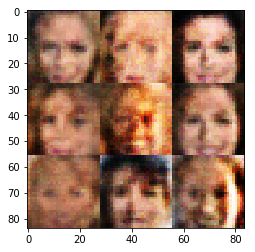

Epoch: 1/1, Batch: 1910/6331 Discriminator Loss: 1.3977 Generator Loss: 0.8450
Epoch: 1/1, Batch: 1920/6331 Discriminator Loss: 1.3664 Generator Loss: 0.8465
Epoch: 1/1, Batch: 1930/6331 Discriminator Loss: 1.4024 Generator Loss: 0.8049
Epoch: 1/1, Batch: 1940/6331 Discriminator Loss: 1.4022 Generator Loss: 0.8608
Epoch: 1/1, Batch: 1950/6331 Discriminator Loss: 1.3674 Generator Loss: 0.8172
Epoch: 1/1, Batch: 1960/6331 Discriminator Loss: 1.3801 Generator Loss: 0.8528
Epoch: 1/1, Batch: 1970/6331 Discriminator Loss: 1.4070 Generator Loss: 0.8469
Epoch: 1/1, Batch: 1980/6331 Discriminator Loss: 1.3926 Generator Loss: 0.7649
Epoch: 1/1, Batch: 1990/6331 Discriminator Loss: 1.4370 Generator Loss: 0.7353
Epoch: 1/1, Batch: 2000/6331 Discriminator Loss: 1.4036 Generator Loss: 0.7254


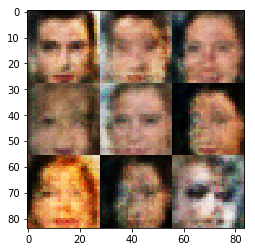

Epoch: 1/1, Batch: 2010/6331 Discriminator Loss: 1.4011 Generator Loss: 0.6929
Epoch: 1/1, Batch: 2020/6331 Discriminator Loss: 1.3995 Generator Loss: 0.7987
Epoch: 1/1, Batch: 2030/6331 Discriminator Loss: 1.3948 Generator Loss: 0.8066
Epoch: 1/1, Batch: 2040/6331 Discriminator Loss: 1.4085 Generator Loss: 0.6890
Epoch: 1/1, Batch: 2050/6331 Discriminator Loss: 1.4061 Generator Loss: 0.7503
Epoch: 1/1, Batch: 2060/6331 Discriminator Loss: 1.4152 Generator Loss: 0.6740
Epoch: 1/1, Batch: 2070/6331 Discriminator Loss: 1.3888 Generator Loss: 0.8036
Epoch: 1/1, Batch: 2080/6331 Discriminator Loss: 1.3933 Generator Loss: 0.7837
Epoch: 1/1, Batch: 2090/6331 Discriminator Loss: 1.3820 Generator Loss: 0.7611
Epoch: 1/1, Batch: 2100/6331 Discriminator Loss: 1.4061 Generator Loss: 0.8510


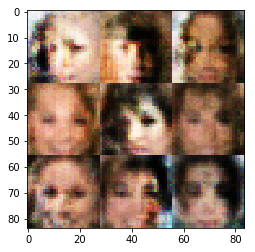

Epoch: 1/1, Batch: 2110/6331 Discriminator Loss: 1.4102 Generator Loss: 0.7697
Epoch: 1/1, Batch: 2120/6331 Discriminator Loss: 1.3800 Generator Loss: 0.7866
Epoch: 1/1, Batch: 2130/6331 Discriminator Loss: 1.4102 Generator Loss: 0.8726
Epoch: 1/1, Batch: 2140/6331 Discriminator Loss: 1.3830 Generator Loss: 0.7520
Epoch: 1/1, Batch: 2150/6331 Discriminator Loss: 1.3884 Generator Loss: 0.7504
Epoch: 1/1, Batch: 2160/6331 Discriminator Loss: 1.3959 Generator Loss: 0.8228
Epoch: 1/1, Batch: 2170/6331 Discriminator Loss: 1.4098 Generator Loss: 0.6429
Epoch: 1/1, Batch: 2180/6331 Discriminator Loss: 1.3985 Generator Loss: 0.7579
Epoch: 1/1, Batch: 2190/6331 Discriminator Loss: 1.3941 Generator Loss: 0.7552
Epoch: 1/1, Batch: 2200/6331 Discriminator Loss: 1.4184 Generator Loss: 0.6326


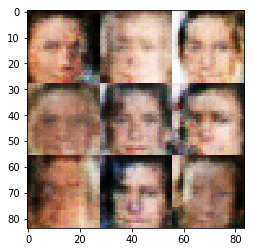

Epoch: 1/1, Batch: 2210/6331 Discriminator Loss: 1.3981 Generator Loss: 0.8658
Epoch: 1/1, Batch: 2220/6331 Discriminator Loss: 1.4272 Generator Loss: 0.7059
Epoch: 1/1, Batch: 2230/6331 Discriminator Loss: 1.4069 Generator Loss: 0.7005
Epoch: 1/1, Batch: 2240/6331 Discriminator Loss: 1.3984 Generator Loss: 0.7652
Epoch: 1/1, Batch: 2250/6331 Discriminator Loss: 1.3782 Generator Loss: 0.7965
Epoch: 1/1, Batch: 2260/6331 Discriminator Loss: 1.4446 Generator Loss: 0.6192
Epoch: 1/1, Batch: 2270/6331 Discriminator Loss: 1.3846 Generator Loss: 0.7727
Epoch: 1/1, Batch: 2280/6331 Discriminator Loss: 1.3866 Generator Loss: 0.7578
Epoch: 1/1, Batch: 2290/6331 Discriminator Loss: 1.4194 Generator Loss: 0.6671
Epoch: 1/1, Batch: 2300/6331 Discriminator Loss: 1.4060 Generator Loss: 0.7884


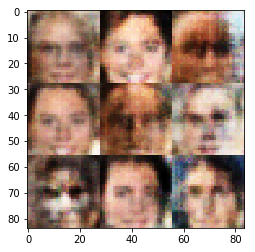

Epoch: 1/1, Batch: 2310/6331 Discriminator Loss: 1.3966 Generator Loss: 0.7242
Epoch: 1/1, Batch: 2320/6331 Discriminator Loss: 1.4045 Generator Loss: 0.7749
Epoch: 1/1, Batch: 2330/6331 Discriminator Loss: 1.4315 Generator Loss: 0.6231
Epoch: 1/1, Batch: 2340/6331 Discriminator Loss: 1.3916 Generator Loss: 0.7767
Epoch: 1/1, Batch: 2350/6331 Discriminator Loss: 1.4139 Generator Loss: 0.9309
Epoch: 1/1, Batch: 2360/6331 Discriminator Loss: 1.4033 Generator Loss: 0.8580
Epoch: 1/1, Batch: 2370/6331 Discriminator Loss: 1.4143 Generator Loss: 0.7272
Epoch: 1/1, Batch: 2380/6331 Discriminator Loss: 1.4026 Generator Loss: 0.7831
Epoch: 1/1, Batch: 2390/6331 Discriminator Loss: 1.3871 Generator Loss: 0.7729
Epoch: 1/1, Batch: 2400/6331 Discriminator Loss: 1.4017 Generator Loss: 0.7242


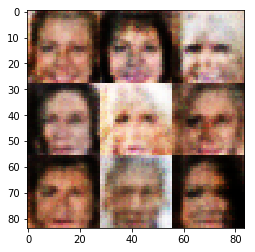

Epoch: 1/1, Batch: 2410/6331 Discriminator Loss: 1.3951 Generator Loss: 0.7417
Epoch: 1/1, Batch: 2420/6331 Discriminator Loss: 1.4242 Generator Loss: 0.7467
Epoch: 1/1, Batch: 2430/6331 Discriminator Loss: 1.4032 Generator Loss: 0.8095
Epoch: 1/1, Batch: 2440/6331 Discriminator Loss: 1.4107 Generator Loss: 0.7128
Epoch: 1/1, Batch: 2450/6331 Discriminator Loss: 1.3894 Generator Loss: 0.7603
Epoch: 1/1, Batch: 2460/6331 Discriminator Loss: 1.4272 Generator Loss: 0.7796
Epoch: 1/1, Batch: 2470/6331 Discriminator Loss: 1.4310 Generator Loss: 0.6964
Epoch: 1/1, Batch: 2480/6331 Discriminator Loss: 1.3854 Generator Loss: 0.6964
Epoch: 1/1, Batch: 2490/6331 Discriminator Loss: 1.3828 Generator Loss: 0.8181
Epoch: 1/1, Batch: 2500/6331 Discriminator Loss: 1.4022 Generator Loss: 0.8781


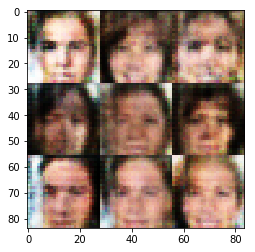

Epoch: 1/1, Batch: 2510/6331 Discriminator Loss: 1.3698 Generator Loss: 0.7640
Epoch: 1/1, Batch: 2520/6331 Discriminator Loss: 1.4087 Generator Loss: 0.7416
Epoch: 1/1, Batch: 2530/6331 Discriminator Loss: 1.3722 Generator Loss: 0.7210
Epoch: 1/1, Batch: 2540/6331 Discriminator Loss: 1.3833 Generator Loss: 0.7661
Epoch: 1/1, Batch: 2550/6331 Discriminator Loss: 1.3848 Generator Loss: 0.7720
Epoch: 1/1, Batch: 2560/6331 Discriminator Loss: 1.3867 Generator Loss: 0.7927
Epoch: 1/1, Batch: 2570/6331 Discriminator Loss: 1.3779 Generator Loss: 0.7668
Epoch: 1/1, Batch: 2580/6331 Discriminator Loss: 1.4130 Generator Loss: 0.6396
Epoch: 1/1, Batch: 2590/6331 Discriminator Loss: 1.3765 Generator Loss: 0.7431
Epoch: 1/1, Batch: 2600/6331 Discriminator Loss: 1.3861 Generator Loss: 0.7188


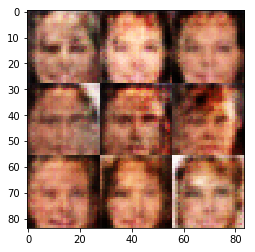

Epoch: 1/1, Batch: 2610/6331 Discriminator Loss: 1.3693 Generator Loss: 0.7501
Epoch: 1/1, Batch: 2620/6331 Discriminator Loss: 1.4103 Generator Loss: 0.8963
Epoch: 1/1, Batch: 2630/6331 Discriminator Loss: 1.3823 Generator Loss: 0.7902
Epoch: 1/1, Batch: 2640/6331 Discriminator Loss: 1.4067 Generator Loss: 0.7269
Epoch: 1/1, Batch: 2650/6331 Discriminator Loss: 1.3944 Generator Loss: 0.6821
Epoch: 1/1, Batch: 2660/6331 Discriminator Loss: 1.4210 Generator Loss: 0.9023
Epoch: 1/1, Batch: 2670/6331 Discriminator Loss: 1.4055 Generator Loss: 0.8562
Epoch: 1/1, Batch: 2680/6331 Discriminator Loss: 1.3896 Generator Loss: 0.7107
Epoch: 1/1, Batch: 2690/6331 Discriminator Loss: 1.3750 Generator Loss: 0.7733
Epoch: 1/1, Batch: 2700/6331 Discriminator Loss: 1.3790 Generator Loss: 0.7933


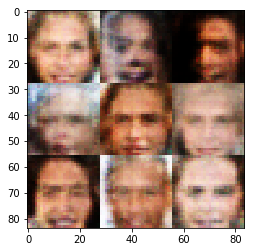

Epoch: 1/1, Batch: 2710/6331 Discriminator Loss: 1.3901 Generator Loss: 0.7459
Epoch: 1/1, Batch: 2720/6331 Discriminator Loss: 1.4073 Generator Loss: 0.7992
Epoch: 1/1, Batch: 2730/6331 Discriminator Loss: 1.4000 Generator Loss: 0.6617
Epoch: 1/1, Batch: 2740/6331 Discriminator Loss: 1.4047 Generator Loss: 0.6802
Epoch: 1/1, Batch: 2750/6331 Discriminator Loss: 1.3990 Generator Loss: 0.7145
Epoch: 1/1, Batch: 2760/6331 Discriminator Loss: 1.3930 Generator Loss: 0.7322
Epoch: 1/1, Batch: 2770/6331 Discriminator Loss: 1.3896 Generator Loss: 0.7861
Epoch: 1/1, Batch: 2780/6331 Discriminator Loss: 1.4039 Generator Loss: 0.7231
Epoch: 1/1, Batch: 2790/6331 Discriminator Loss: 1.3966 Generator Loss: 0.7463
Epoch: 1/1, Batch: 2800/6331 Discriminator Loss: 1.3754 Generator Loss: 0.7635


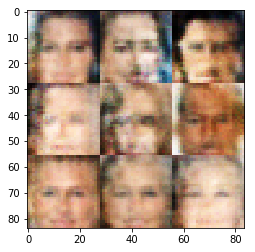

Epoch: 1/1, Batch: 2810/6331 Discriminator Loss: 1.3899 Generator Loss: 0.7296
Epoch: 1/1, Batch: 2820/6331 Discriminator Loss: 1.3722 Generator Loss: 0.7796
Epoch: 1/1, Batch: 2830/6331 Discriminator Loss: 1.3862 Generator Loss: 0.7270
Epoch: 1/1, Batch: 2840/6331 Discriminator Loss: 1.4010 Generator Loss: 0.7392
Epoch: 1/1, Batch: 2850/6331 Discriminator Loss: 1.3895 Generator Loss: 0.7697
Epoch: 1/1, Batch: 2860/6331 Discriminator Loss: 1.4167 Generator Loss: 0.9029
Epoch: 1/1, Batch: 2870/6331 Discriminator Loss: 1.3843 Generator Loss: 0.7518
Epoch: 1/1, Batch: 2880/6331 Discriminator Loss: 1.4016 Generator Loss: 0.8001
Epoch: 1/1, Batch: 2890/6331 Discriminator Loss: 1.4133 Generator Loss: 0.6702
Epoch: 1/1, Batch: 2900/6331 Discriminator Loss: 1.3822 Generator Loss: 0.7796


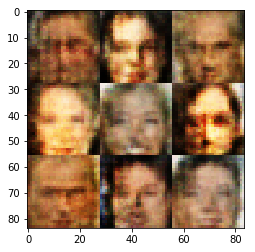

Epoch: 1/1, Batch: 2910/6331 Discriminator Loss: 1.4023 Generator Loss: 0.8760
Epoch: 1/1, Batch: 2920/6331 Discriminator Loss: 1.3928 Generator Loss: 0.7635
Epoch: 1/1, Batch: 2930/6331 Discriminator Loss: 1.3987 Generator Loss: 0.8217
Epoch: 1/1, Batch: 2940/6331 Discriminator Loss: 1.3768 Generator Loss: 0.7783
Epoch: 1/1, Batch: 2950/6331 Discriminator Loss: 1.4000 Generator Loss: 0.7125
Epoch: 1/1, Batch: 2960/6331 Discriminator Loss: 1.3987 Generator Loss: 0.8161
Epoch: 1/1, Batch: 2970/6331 Discriminator Loss: 1.4013 Generator Loss: 0.7920
Epoch: 1/1, Batch: 2980/6331 Discriminator Loss: 1.3905 Generator Loss: 0.8020
Epoch: 1/1, Batch: 2990/6331 Discriminator Loss: 1.3938 Generator Loss: 0.7571
Epoch: 1/1, Batch: 3000/6331 Discriminator Loss: 1.3991 Generator Loss: 0.8168


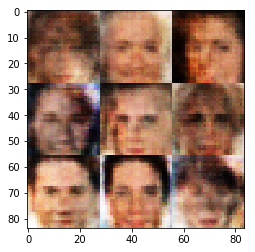

Epoch: 1/1, Batch: 3010/6331 Discriminator Loss: 1.3872 Generator Loss: 0.8399
Epoch: 1/1, Batch: 3020/6331 Discriminator Loss: 1.4055 Generator Loss: 0.7164
Epoch: 1/1, Batch: 3030/6331 Discriminator Loss: 1.4068 Generator Loss: 0.6842
Epoch: 1/1, Batch: 3040/6331 Discriminator Loss: 1.3935 Generator Loss: 0.8400
Epoch: 1/1, Batch: 3050/6331 Discriminator Loss: 1.3889 Generator Loss: 0.7784
Epoch: 1/1, Batch: 3060/6331 Discriminator Loss: 1.3991 Generator Loss: 0.6876
Epoch: 1/1, Batch: 3070/6331 Discriminator Loss: 1.3803 Generator Loss: 0.8191
Epoch: 1/1, Batch: 3080/6331 Discriminator Loss: 1.4110 Generator Loss: 0.8968
Epoch: 1/1, Batch: 3090/6331 Discriminator Loss: 1.3849 Generator Loss: 0.8651
Epoch: 1/1, Batch: 3100/6331 Discriminator Loss: 1.3907 Generator Loss: 0.6981


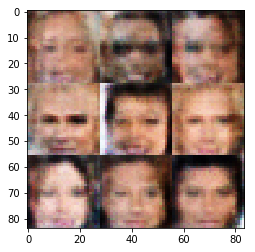

Epoch: 1/1, Batch: 3110/6331 Discriminator Loss: 1.3964 Generator Loss: 0.8029
Epoch: 1/1, Batch: 3120/6331 Discriminator Loss: 1.3992 Generator Loss: 0.7642
Epoch: 1/1, Batch: 3130/6331 Discriminator Loss: 1.3868 Generator Loss: 0.7706
Epoch: 1/1, Batch: 3140/6331 Discriminator Loss: 1.3953 Generator Loss: 0.8095
Epoch: 1/1, Batch: 3150/6331 Discriminator Loss: 1.4009 Generator Loss: 0.7958
Epoch: 1/1, Batch: 3160/6331 Discriminator Loss: 1.3920 Generator Loss: 0.7644
Epoch: 1/1, Batch: 3170/6331 Discriminator Loss: 1.3956 Generator Loss: 0.7200
Epoch: 1/1, Batch: 3180/6331 Discriminator Loss: 1.3987 Generator Loss: 0.7655
Epoch: 1/1, Batch: 3190/6331 Discriminator Loss: 1.3873 Generator Loss: 0.8324
Epoch: 1/1, Batch: 3200/6331 Discriminator Loss: 1.3906 Generator Loss: 0.7670


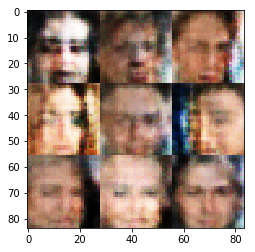

Epoch: 1/1, Batch: 3210/6331 Discriminator Loss: 1.3885 Generator Loss: 0.8451
Epoch: 1/1, Batch: 3220/6331 Discriminator Loss: 1.3956 Generator Loss: 0.7223
Epoch: 1/1, Batch: 3230/6331 Discriminator Loss: 1.3868 Generator Loss: 0.8489
Epoch: 1/1, Batch: 3240/6331 Discriminator Loss: 1.4014 Generator Loss: 0.8662
Epoch: 1/1, Batch: 3250/6331 Discriminator Loss: 1.4063 Generator Loss: 0.7595
Epoch: 1/1, Batch: 3260/6331 Discriminator Loss: 1.3841 Generator Loss: 0.7894
Epoch: 1/1, Batch: 3270/6331 Discriminator Loss: 1.3921 Generator Loss: 0.6684
Epoch: 1/1, Batch: 3280/6331 Discriminator Loss: 1.3734 Generator Loss: 0.7491
Epoch: 1/1, Batch: 3290/6331 Discriminator Loss: 1.3899 Generator Loss: 0.7500
Epoch: 1/1, Batch: 3300/6331 Discriminator Loss: 1.3927 Generator Loss: 0.7613


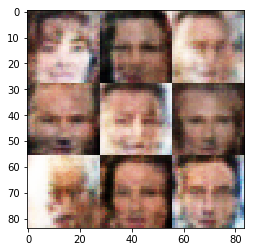

Epoch: 1/1, Batch: 3310/6331 Discriminator Loss: 1.3943 Generator Loss: 0.8342
Epoch: 1/1, Batch: 3320/6331 Discriminator Loss: 1.4245 Generator Loss: 0.7523
Epoch: 1/1, Batch: 3330/6331 Discriminator Loss: 1.3934 Generator Loss: 0.8827
Epoch: 1/1, Batch: 3340/6331 Discriminator Loss: 1.3899 Generator Loss: 0.8444
Epoch: 1/1, Batch: 3350/6331 Discriminator Loss: 1.3775 Generator Loss: 0.8373
Epoch: 1/1, Batch: 3360/6331 Discriminator Loss: 1.3810 Generator Loss: 0.8367
Epoch: 1/1, Batch: 3370/6331 Discriminator Loss: 1.3882 Generator Loss: 0.7849
Epoch: 1/1, Batch: 3380/6331 Discriminator Loss: 1.3940 Generator Loss: 0.8223
Epoch: 1/1, Batch: 3390/6331 Discriminator Loss: 1.4110 Generator Loss: 0.7075
Epoch: 1/1, Batch: 3400/6331 Discriminator Loss: 1.3947 Generator Loss: 0.6739


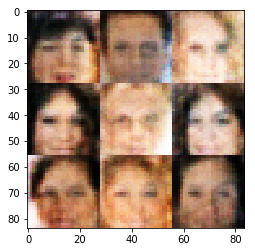

Epoch: 1/1, Batch: 3410/6331 Discriminator Loss: 1.4029 Generator Loss: 0.8237
Epoch: 1/1, Batch: 3420/6331 Discriminator Loss: 1.3987 Generator Loss: 0.8196
Epoch: 1/1, Batch: 3430/6331 Discriminator Loss: 1.4053 Generator Loss: 0.7611
Epoch: 1/1, Batch: 3440/6331 Discriminator Loss: 1.3930 Generator Loss: 0.8401
Epoch: 1/1, Batch: 3450/6331 Discriminator Loss: 1.3825 Generator Loss: 0.8067
Epoch: 1/1, Batch: 3460/6331 Discriminator Loss: 1.3809 Generator Loss: 0.7916
Epoch: 1/1, Batch: 3470/6331 Discriminator Loss: 1.4022 Generator Loss: 0.7436
Epoch: 1/1, Batch: 3480/6331 Discriminator Loss: 1.4047 Generator Loss: 0.7292
Epoch: 1/1, Batch: 3490/6331 Discriminator Loss: 1.3960 Generator Loss: 0.7672
Epoch: 1/1, Batch: 3500/6331 Discriminator Loss: 1.3915 Generator Loss: 0.7956


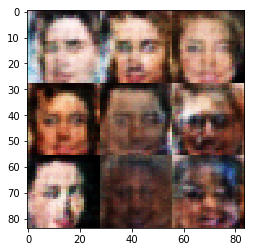

Epoch: 1/1, Batch: 3510/6331 Discriminator Loss: 1.3943 Generator Loss: 0.6888
Epoch: 1/1, Batch: 3520/6331 Discriminator Loss: 1.3996 Generator Loss: 0.7251
Epoch: 1/1, Batch: 3530/6331 Discriminator Loss: 1.3874 Generator Loss: 0.7447
Epoch: 1/1, Batch: 3540/6331 Discriminator Loss: 1.3889 Generator Loss: 0.7366
Epoch: 1/1, Batch: 3550/6331 Discriminator Loss: 1.3902 Generator Loss: 0.7195
Epoch: 1/1, Batch: 3560/6331 Discriminator Loss: 1.3932 Generator Loss: 0.8534
Epoch: 1/1, Batch: 3570/6331 Discriminator Loss: 1.4115 Generator Loss: 0.7489
Epoch: 1/1, Batch: 3580/6331 Discriminator Loss: 1.3879 Generator Loss: 0.8784
Epoch: 1/1, Batch: 3590/6331 Discriminator Loss: 1.3874 Generator Loss: 0.7482
Epoch: 1/1, Batch: 3600/6331 Discriminator Loss: 1.3914 Generator Loss: 0.8011


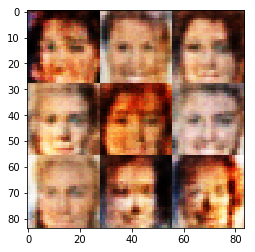

Epoch: 1/1, Batch: 3610/6331 Discriminator Loss: 1.3952 Generator Loss: 0.7665
Epoch: 1/1, Batch: 3620/6331 Discriminator Loss: 1.3937 Generator Loss: 0.7712
Epoch: 1/1, Batch: 3630/6331 Discriminator Loss: 1.3848 Generator Loss: 0.8112
Epoch: 1/1, Batch: 3640/6331 Discriminator Loss: 1.3758 Generator Loss: 0.7929
Epoch: 1/1, Batch: 3650/6331 Discriminator Loss: 1.3836 Generator Loss: 0.7886
Epoch: 1/1, Batch: 3660/6331 Discriminator Loss: 1.3995 Generator Loss: 0.8738
Epoch: 1/1, Batch: 3670/6331 Discriminator Loss: 1.3858 Generator Loss: 0.7350
Epoch: 1/1, Batch: 3680/6331 Discriminator Loss: 1.3940 Generator Loss: 0.7601
Epoch: 1/1, Batch: 3690/6331 Discriminator Loss: 1.3852 Generator Loss: 0.8022
Epoch: 1/1, Batch: 3700/6331 Discriminator Loss: 1.3926 Generator Loss: 0.7011


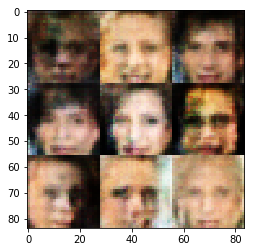

Epoch: 1/1, Batch: 3710/6331 Discriminator Loss: 1.3907 Generator Loss: 0.7605
Epoch: 1/1, Batch: 3720/6331 Discriminator Loss: 1.3978 Generator Loss: 0.8777
Epoch: 1/1, Batch: 3730/6331 Discriminator Loss: 1.3869 Generator Loss: 0.7644
Epoch: 1/1, Batch: 3740/6331 Discriminator Loss: 1.3990 Generator Loss: 0.7178
Epoch: 1/1, Batch: 3750/6331 Discriminator Loss: 1.3992 Generator Loss: 0.7605
Epoch: 1/1, Batch: 3760/6331 Discriminator Loss: 1.4028 Generator Loss: 0.8320
Epoch: 1/1, Batch: 3770/6331 Discriminator Loss: 1.3807 Generator Loss: 0.8102
Epoch: 1/1, Batch: 3780/6331 Discriminator Loss: 1.3950 Generator Loss: 0.7970
Epoch: 1/1, Batch: 3790/6331 Discriminator Loss: 1.3914 Generator Loss: 0.8072
Epoch: 1/1, Batch: 3800/6331 Discriminator Loss: 1.3868 Generator Loss: 0.7681


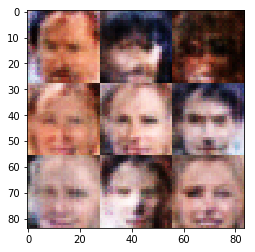

Epoch: 1/1, Batch: 3810/6331 Discriminator Loss: 1.3753 Generator Loss: 0.7872
Epoch: 1/1, Batch: 3820/6331 Discriminator Loss: 1.3912 Generator Loss: 0.8276
Epoch: 1/1, Batch: 3830/6331 Discriminator Loss: 1.3855 Generator Loss: 0.7883
Epoch: 1/1, Batch: 3840/6331 Discriminator Loss: 1.3741 Generator Loss: 0.8350
Epoch: 1/1, Batch: 3850/6331 Discriminator Loss: 1.3957 Generator Loss: 0.7218
Epoch: 1/1, Batch: 3860/6331 Discriminator Loss: 1.3916 Generator Loss: 0.7406
Epoch: 1/1, Batch: 3870/6331 Discriminator Loss: 1.3941 Generator Loss: 0.8316
Epoch: 1/1, Batch: 3880/6331 Discriminator Loss: 1.3991 Generator Loss: 0.8914
Epoch: 1/1, Batch: 3890/6331 Discriminator Loss: 1.3933 Generator Loss: 0.7286
Epoch: 1/1, Batch: 3900/6331 Discriminator Loss: 1.3863 Generator Loss: 0.7730


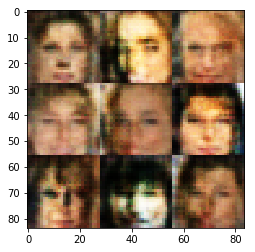

Epoch: 1/1, Batch: 3910/6331 Discriminator Loss: 1.3988 Generator Loss: 0.8450
Epoch: 1/1, Batch: 3920/6331 Discriminator Loss: 1.3813 Generator Loss: 0.7690
Epoch: 1/1, Batch: 3930/6331 Discriminator Loss: 1.4055 Generator Loss: 0.6745
Epoch: 1/1, Batch: 3940/6331 Discriminator Loss: 1.4052 Generator Loss: 0.7902
Epoch: 1/1, Batch: 3950/6331 Discriminator Loss: 1.3948 Generator Loss: 0.7556
Epoch: 1/1, Batch: 3960/6331 Discriminator Loss: 1.4052 Generator Loss: 0.8387
Epoch: 1/1, Batch: 3970/6331 Discriminator Loss: 1.3982 Generator Loss: 0.7395
Epoch: 1/1, Batch: 3980/6331 Discriminator Loss: 1.4039 Generator Loss: 0.7703
Epoch: 1/1, Batch: 3990/6331 Discriminator Loss: 1.3894 Generator Loss: 0.7298
Epoch: 1/1, Batch: 4000/6331 Discriminator Loss: 1.4033 Generator Loss: 0.7333


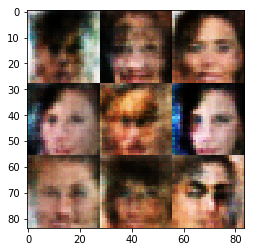

Epoch: 1/1, Batch: 4010/6331 Discriminator Loss: 1.3944 Generator Loss: 0.8796
Epoch: 1/1, Batch: 4020/6331 Discriminator Loss: 1.4021 Generator Loss: 0.7419
Epoch: 1/1, Batch: 4030/6331 Discriminator Loss: 1.4186 Generator Loss: 0.6401
Epoch: 1/1, Batch: 4040/6331 Discriminator Loss: 1.4018 Generator Loss: 0.7018
Epoch: 1/1, Batch: 4050/6331 Discriminator Loss: 1.3933 Generator Loss: 0.7150
Epoch: 1/1, Batch: 4060/6331 Discriminator Loss: 1.3778 Generator Loss: 0.8080
Epoch: 1/1, Batch: 4070/6331 Discriminator Loss: 1.3760 Generator Loss: 0.8304
Epoch: 1/1, Batch: 4080/6331 Discriminator Loss: 1.4090 Generator Loss: 0.7013
Epoch: 1/1, Batch: 4090/6331 Discriminator Loss: 1.3877 Generator Loss: 0.7932
Epoch: 1/1, Batch: 4100/6331 Discriminator Loss: 1.3931 Generator Loss: 0.7436


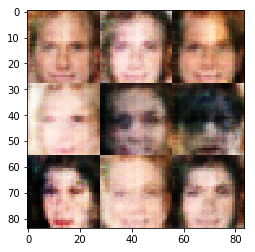

Epoch: 1/1, Batch: 4110/6331 Discriminator Loss: 1.3774 Generator Loss: 0.7903
Epoch: 1/1, Batch: 4120/6331 Discriminator Loss: 1.3881 Generator Loss: 0.8217
Epoch: 1/1, Batch: 4130/6331 Discriminator Loss: 1.3948 Generator Loss: 0.7770
Epoch: 1/1, Batch: 4140/6331 Discriminator Loss: 1.3828 Generator Loss: 0.7864
Epoch: 1/1, Batch: 4150/6331 Discriminator Loss: 1.3949 Generator Loss: 0.7007
Epoch: 1/1, Batch: 4160/6331 Discriminator Loss: 1.3890 Generator Loss: 0.7938
Epoch: 1/1, Batch: 4170/6331 Discriminator Loss: 1.3872 Generator Loss: 0.7425
Epoch: 1/1, Batch: 4180/6331 Discriminator Loss: 1.3962 Generator Loss: 0.8392
Epoch: 1/1, Batch: 4190/6331 Discriminator Loss: 1.3884 Generator Loss: 0.8339
Epoch: 1/1, Batch: 4200/6331 Discriminator Loss: 1.3923 Generator Loss: 0.7540


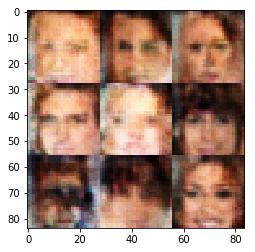

Epoch: 1/1, Batch: 4210/6331 Discriminator Loss: 1.3907 Generator Loss: 0.7696
Epoch: 1/1, Batch: 4220/6331 Discriminator Loss: 1.3838 Generator Loss: 0.7183
Epoch: 1/1, Batch: 4230/6331 Discriminator Loss: 1.3973 Generator Loss: 0.7052
Epoch: 1/1, Batch: 4240/6331 Discriminator Loss: 1.3996 Generator Loss: 0.6936
Epoch: 1/1, Batch: 4250/6331 Discriminator Loss: 1.3956 Generator Loss: 0.8072
Epoch: 1/1, Batch: 4260/6331 Discriminator Loss: 1.3882 Generator Loss: 0.8091
Epoch: 1/1, Batch: 4270/6331 Discriminator Loss: 1.3811 Generator Loss: 0.7659
Epoch: 1/1, Batch: 4280/6331 Discriminator Loss: 1.3973 Generator Loss: 0.8863
Epoch: 1/1, Batch: 4290/6331 Discriminator Loss: 1.4032 Generator Loss: 0.9211
Epoch: 1/1, Batch: 4300/6331 Discriminator Loss: 1.3946 Generator Loss: 0.8403


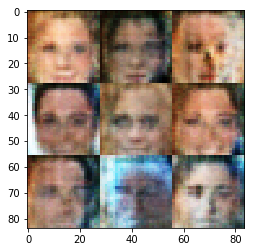

Epoch: 1/1, Batch: 4310/6331 Discriminator Loss: 1.3887 Generator Loss: 0.7932
Epoch: 1/1, Batch: 4320/6331 Discriminator Loss: 1.3860 Generator Loss: 0.7553
Epoch: 1/1, Batch: 4330/6331 Discriminator Loss: 1.3890 Generator Loss: 0.7827
Epoch: 1/1, Batch: 4340/6331 Discriminator Loss: 1.3860 Generator Loss: 0.7138
Epoch: 1/1, Batch: 4350/6331 Discriminator Loss: 1.3835 Generator Loss: 0.7986
Epoch: 1/1, Batch: 4360/6331 Discriminator Loss: 1.3787 Generator Loss: 0.8263
Epoch: 1/1, Batch: 4370/6331 Discriminator Loss: 1.3869 Generator Loss: 0.7669
Epoch: 1/1, Batch: 4380/6331 Discriminator Loss: 1.3938 Generator Loss: 0.8314
Epoch: 1/1, Batch: 4390/6331 Discriminator Loss: 1.3834 Generator Loss: 0.7808
Epoch: 1/1, Batch: 4400/6331 Discriminator Loss: 1.3931 Generator Loss: 0.7559


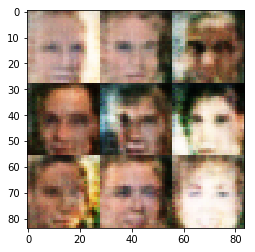

Epoch: 1/1, Batch: 4410/6331 Discriminator Loss: 1.3849 Generator Loss: 0.7669
Epoch: 1/1, Batch: 4420/6331 Discriminator Loss: 1.4120 Generator Loss: 0.7163
Epoch: 1/1, Batch: 4430/6331 Discriminator Loss: 1.3966 Generator Loss: 0.8465
Epoch: 1/1, Batch: 4440/6331 Discriminator Loss: 1.3827 Generator Loss: 0.7998
Epoch: 1/1, Batch: 4450/6331 Discriminator Loss: 1.3958 Generator Loss: 0.7344
Epoch: 1/1, Batch: 4460/6331 Discriminator Loss: 1.3838 Generator Loss: 0.8335
Epoch: 1/1, Batch: 4470/6331 Discriminator Loss: 1.3765 Generator Loss: 0.7860
Epoch: 1/1, Batch: 4480/6331 Discriminator Loss: 1.4024 Generator Loss: 0.7055
Epoch: 1/1, Batch: 4490/6331 Discriminator Loss: 1.3816 Generator Loss: 0.7849
Epoch: 1/1, Batch: 4500/6331 Discriminator Loss: 1.3872 Generator Loss: 0.7357


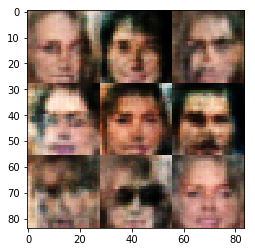

Epoch: 1/1, Batch: 4510/6331 Discriminator Loss: 1.3968 Generator Loss: 0.7001
Epoch: 1/1, Batch: 4520/6331 Discriminator Loss: 1.3989 Generator Loss: 0.8307
Epoch: 1/1, Batch: 4530/6331 Discriminator Loss: 1.4036 Generator Loss: 0.8355
Epoch: 1/1, Batch: 4540/6331 Discriminator Loss: 1.3918 Generator Loss: 0.7315
Epoch: 1/1, Batch: 4550/6331 Discriminator Loss: 1.3912 Generator Loss: 0.7743
Epoch: 1/1, Batch: 4560/6331 Discriminator Loss: 1.3756 Generator Loss: 0.7611
Epoch: 1/1, Batch: 4570/6331 Discriminator Loss: 1.3804 Generator Loss: 0.7554
Epoch: 1/1, Batch: 4580/6331 Discriminator Loss: 1.3911 Generator Loss: 0.7855
Epoch: 1/1, Batch: 4590/6331 Discriminator Loss: 1.3932 Generator Loss: 0.8615
Epoch: 1/1, Batch: 4600/6331 Discriminator Loss: 1.3841 Generator Loss: 0.8219


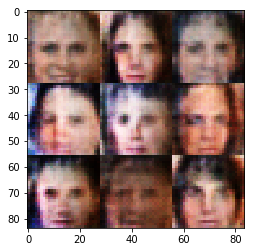

Epoch: 1/1, Batch: 4610/6331 Discriminator Loss: 1.3923 Generator Loss: 0.7362
Epoch: 1/1, Batch: 4620/6331 Discriminator Loss: 1.3929 Generator Loss: 0.6787
Epoch: 1/1, Batch: 4630/6331 Discriminator Loss: 1.3822 Generator Loss: 0.7740
Epoch: 1/1, Batch: 4640/6331 Discriminator Loss: 1.4078 Generator Loss: 0.6795
Epoch: 1/1, Batch: 4650/6331 Discriminator Loss: 1.3865 Generator Loss: 0.8474
Epoch: 1/1, Batch: 4660/6331 Discriminator Loss: 1.3856 Generator Loss: 0.7335
Epoch: 1/1, Batch: 4670/6331 Discriminator Loss: 1.3786 Generator Loss: 0.7847
Epoch: 1/1, Batch: 4680/6331 Discriminator Loss: 1.3943 Generator Loss: 0.7145
Epoch: 1/1, Batch: 4690/6331 Discriminator Loss: 1.3830 Generator Loss: 0.7904
Epoch: 1/1, Batch: 4700/6331 Discriminator Loss: 1.3885 Generator Loss: 0.8811


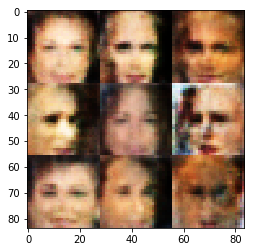

Epoch: 1/1, Batch: 4710/6331 Discriminator Loss: 1.3951 Generator Loss: 0.7900
Epoch: 1/1, Batch: 4720/6331 Discriminator Loss: 1.3964 Generator Loss: 0.6550
Epoch: 1/1, Batch: 4730/6331 Discriminator Loss: 1.4041 Generator Loss: 0.7115
Epoch: 1/1, Batch: 4740/6331 Discriminator Loss: 1.3953 Generator Loss: 0.8186
Epoch: 1/1, Batch: 4750/6331 Discriminator Loss: 1.3775 Generator Loss: 0.7352
Epoch: 1/1, Batch: 4760/6331 Discriminator Loss: 1.4082 Generator Loss: 0.7795
Epoch: 1/1, Batch: 4770/6331 Discriminator Loss: 1.3946 Generator Loss: 0.7232
Epoch: 1/1, Batch: 4780/6331 Discriminator Loss: 1.3869 Generator Loss: 0.7806
Epoch: 1/1, Batch: 4790/6331 Discriminator Loss: 1.3893 Generator Loss: 0.8122
Epoch: 1/1, Batch: 4800/6331 Discriminator Loss: 1.3850 Generator Loss: 0.7388


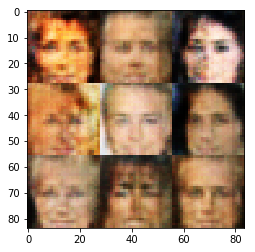

Epoch: 1/1, Batch: 4810/6331 Discriminator Loss: 1.4036 Generator Loss: 0.6640
Epoch: 1/1, Batch: 4820/6331 Discriminator Loss: 1.3930 Generator Loss: 0.7323
Epoch: 1/1, Batch: 4830/6331 Discriminator Loss: 1.3991 Generator Loss: 0.6872
Epoch: 1/1, Batch: 4840/6331 Discriminator Loss: 1.3896 Generator Loss: 0.8523
Epoch: 1/1, Batch: 4850/6331 Discriminator Loss: 1.4092 Generator Loss: 0.9046
Epoch: 1/1, Batch: 4860/6331 Discriminator Loss: 1.4059 Generator Loss: 0.6602
Epoch: 1/1, Batch: 4870/6331 Discriminator Loss: 1.3962 Generator Loss: 0.8948
Epoch: 1/1, Batch: 4880/6331 Discriminator Loss: 1.3852 Generator Loss: 0.7393
Epoch: 1/1, Batch: 4890/6331 Discriminator Loss: 1.3920 Generator Loss: 0.7017
Epoch: 1/1, Batch: 4900/6331 Discriminator Loss: 1.3937 Generator Loss: 0.7811


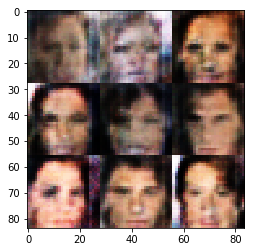

Epoch: 1/1, Batch: 4910/6331 Discriminator Loss: 1.3856 Generator Loss: 0.7660
Epoch: 1/1, Batch: 4920/6331 Discriminator Loss: 1.3773 Generator Loss: 0.7694
Epoch: 1/1, Batch: 4930/6331 Discriminator Loss: 1.3898 Generator Loss: 0.7468
Epoch: 1/1, Batch: 4940/6331 Discriminator Loss: 1.3890 Generator Loss: 0.7597
Epoch: 1/1, Batch: 4950/6331 Discriminator Loss: 1.3823 Generator Loss: 0.7577
Epoch: 1/1, Batch: 4960/6331 Discriminator Loss: 1.3858 Generator Loss: 0.7540
Epoch: 1/1, Batch: 4970/6331 Discriminator Loss: 1.3793 Generator Loss: 0.7769
Epoch: 1/1, Batch: 4980/6331 Discriminator Loss: 1.3903 Generator Loss: 0.8241
Epoch: 1/1, Batch: 4990/6331 Discriminator Loss: 1.3855 Generator Loss: 0.8257
Epoch: 1/1, Batch: 5000/6331 Discriminator Loss: 1.3768 Generator Loss: 0.7407


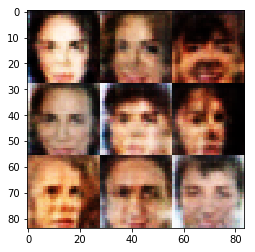

Epoch: 1/1, Batch: 5010/6331 Discriminator Loss: 1.3843 Generator Loss: 0.7932
Epoch: 1/1, Batch: 5020/6331 Discriminator Loss: 1.3967 Generator Loss: 0.7324
Epoch: 1/1, Batch: 5030/6331 Discriminator Loss: 1.3822 Generator Loss: 0.7818
Epoch: 1/1, Batch: 5040/6331 Discriminator Loss: 1.3862 Generator Loss: 0.7119
Epoch: 1/1, Batch: 5050/6331 Discriminator Loss: 1.3897 Generator Loss: 0.7089
Epoch: 1/1, Batch: 5060/6331 Discriminator Loss: 1.3828 Generator Loss: 0.8348
Epoch: 1/1, Batch: 5070/6331 Discriminator Loss: 1.3831 Generator Loss: 0.8420
Epoch: 1/1, Batch: 5080/6331 Discriminator Loss: 1.3788 Generator Loss: 0.7498
Epoch: 1/1, Batch: 5090/6331 Discriminator Loss: 1.3761 Generator Loss: 0.8363
Epoch: 1/1, Batch: 5100/6331 Discriminator Loss: 1.3835 Generator Loss: 0.7912


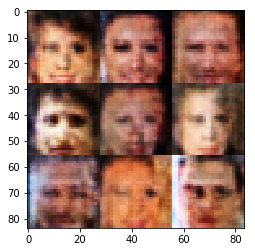

Epoch: 1/1, Batch: 5110/6331 Discriminator Loss: 1.3938 Generator Loss: 0.8027
Epoch: 1/1, Batch: 5120/6331 Discriminator Loss: 1.3825 Generator Loss: 0.7573
Epoch: 1/1, Batch: 5130/6331 Discriminator Loss: 1.3815 Generator Loss: 0.7496
Epoch: 1/1, Batch: 5140/6331 Discriminator Loss: 1.3857 Generator Loss: 0.7936
Epoch: 1/1, Batch: 5150/6331 Discriminator Loss: 1.3771 Generator Loss: 0.8346
Epoch: 1/1, Batch: 5160/6331 Discriminator Loss: 1.3940 Generator Loss: 0.7024
Epoch: 1/1, Batch: 5170/6331 Discriminator Loss: 1.3949 Generator Loss: 0.8757
Epoch: 1/1, Batch: 5180/6331 Discriminator Loss: 1.3947 Generator Loss: 0.7962
Epoch: 1/1, Batch: 5190/6331 Discriminator Loss: 1.3920 Generator Loss: 0.7452
Epoch: 1/1, Batch: 5200/6331 Discriminator Loss: 1.3840 Generator Loss: 0.8338


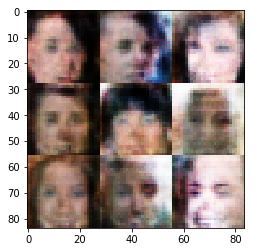

Epoch: 1/1, Batch: 5210/6331 Discriminator Loss: 1.3879 Generator Loss: 0.8112
Epoch: 1/1, Batch: 5220/6331 Discriminator Loss: 1.3874 Generator Loss: 0.7863
Epoch: 1/1, Batch: 5230/6331 Discriminator Loss: 1.3896 Generator Loss: 0.8493
Epoch: 1/1, Batch: 5240/6331 Discriminator Loss: 1.3883 Generator Loss: 0.8075
Epoch: 1/1, Batch: 5250/6331 Discriminator Loss: 1.3858 Generator Loss: 0.8472
Epoch: 1/1, Batch: 5260/6331 Discriminator Loss: 1.3905 Generator Loss: 0.7312
Epoch: 1/1, Batch: 5270/6331 Discriminator Loss: 1.3989 Generator Loss: 0.8231
Epoch: 1/1, Batch: 5280/6331 Discriminator Loss: 1.3881 Generator Loss: 0.7539
Epoch: 1/1, Batch: 5290/6331 Discriminator Loss: 1.3856 Generator Loss: 0.7667
Epoch: 1/1, Batch: 5300/6331 Discriminator Loss: 1.3946 Generator Loss: 0.7547


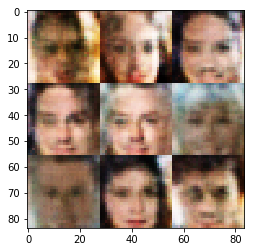

Epoch: 1/1, Batch: 5310/6331 Discriminator Loss: 1.3957 Generator Loss: 0.8063
Epoch: 1/1, Batch: 5320/6331 Discriminator Loss: 1.3958 Generator Loss: 0.6884
Epoch: 1/1, Batch: 5330/6331 Discriminator Loss: 1.3747 Generator Loss: 0.8202
Epoch: 1/1, Batch: 5340/6331 Discriminator Loss: 1.3703 Generator Loss: 0.7533
Epoch: 1/1, Batch: 5350/6331 Discriminator Loss: 1.4039 Generator Loss: 0.6797
Epoch: 1/1, Batch: 5360/6331 Discriminator Loss: 1.3868 Generator Loss: 0.7455
Epoch: 1/1, Batch: 5370/6331 Discriminator Loss: 1.3860 Generator Loss: 0.8164
Epoch: 1/1, Batch: 5380/6331 Discriminator Loss: 1.4054 Generator Loss: 0.8571
Epoch: 1/1, Batch: 5390/6331 Discriminator Loss: 1.3817 Generator Loss: 0.8195
Epoch: 1/1, Batch: 5400/6331 Discriminator Loss: 1.3953 Generator Loss: 0.7900


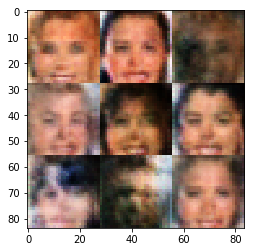

Epoch: 1/1, Batch: 5410/6331 Discriminator Loss: 1.3860 Generator Loss: 0.7144
Epoch: 1/1, Batch: 5420/6331 Discriminator Loss: 1.3789 Generator Loss: 0.8066
Epoch: 1/1, Batch: 5430/6331 Discriminator Loss: 1.3827 Generator Loss: 0.7751
Epoch: 1/1, Batch: 5440/6331 Discriminator Loss: 1.3869 Generator Loss: 0.6957
Epoch: 1/1, Batch: 5450/6331 Discriminator Loss: 1.3842 Generator Loss: 0.7926
Epoch: 1/1, Batch: 5460/6331 Discriminator Loss: 1.3974 Generator Loss: 0.7259
Epoch: 1/1, Batch: 5470/6331 Discriminator Loss: 1.3813 Generator Loss: 0.7967
Epoch: 1/1, Batch: 5480/6331 Discriminator Loss: 1.3820 Generator Loss: 0.7758
Epoch: 1/1, Batch: 5490/6331 Discriminator Loss: 1.3856 Generator Loss: 0.8097
Epoch: 1/1, Batch: 5500/6331 Discriminator Loss: 1.3736 Generator Loss: 0.7903


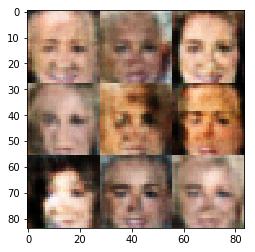

Epoch: 1/1, Batch: 5510/6331 Discriminator Loss: 1.3812 Generator Loss: 0.7646
Epoch: 1/1, Batch: 5520/6331 Discriminator Loss: 1.3988 Generator Loss: 0.8330
Epoch: 1/1, Batch: 5530/6331 Discriminator Loss: 1.3923 Generator Loss: 0.7775
Epoch: 1/1, Batch: 5540/6331 Discriminator Loss: 1.3905 Generator Loss: 0.7768
Epoch: 1/1, Batch: 5550/6331 Discriminator Loss: 1.3935 Generator Loss: 0.8183
Epoch: 1/1, Batch: 5560/6331 Discriminator Loss: 1.3892 Generator Loss: 0.7258
Epoch: 1/1, Batch: 5570/6331 Discriminator Loss: 1.3988 Generator Loss: 0.7117
Epoch: 1/1, Batch: 5580/6331 Discriminator Loss: 1.3955 Generator Loss: 0.7405
Epoch: 1/1, Batch: 5590/6331 Discriminator Loss: 1.3834 Generator Loss: 0.8220
Epoch: 1/1, Batch: 5600/6331 Discriminator Loss: 1.3863 Generator Loss: 0.8148


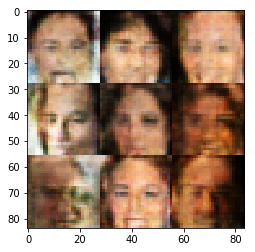

Epoch: 1/1, Batch: 5610/6331 Discriminator Loss: 1.3954 Generator Loss: 0.8416
Epoch: 1/1, Batch: 5620/6331 Discriminator Loss: 1.3845 Generator Loss: 0.7933
Epoch: 1/1, Batch: 5630/6331 Discriminator Loss: 1.4027 Generator Loss: 0.7527
Epoch: 1/1, Batch: 5640/6331 Discriminator Loss: 1.3832 Generator Loss: 0.8980
Epoch: 1/1, Batch: 5650/6331 Discriminator Loss: 1.4001 Generator Loss: 0.6917
Epoch: 1/1, Batch: 5660/6331 Discriminator Loss: 1.3865 Generator Loss: 0.7760
Epoch: 1/1, Batch: 5670/6331 Discriminator Loss: 1.3895 Generator Loss: 0.7735
Epoch: 1/1, Batch: 5680/6331 Discriminator Loss: 1.3988 Generator Loss: 0.7061
Epoch: 1/1, Batch: 5690/6331 Discriminator Loss: 1.3772 Generator Loss: 0.8601
Epoch: 1/1, Batch: 5700/6331 Discriminator Loss: 1.3960 Generator Loss: 0.7877


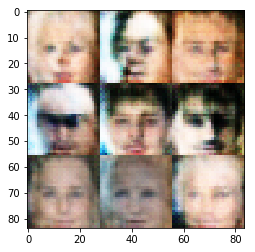

Epoch: 1/1, Batch: 5710/6331 Discriminator Loss: 1.3801 Generator Loss: 0.7482
Epoch: 1/1, Batch: 5720/6331 Discriminator Loss: 1.4250 Generator Loss: 0.6701
Epoch: 1/1, Batch: 5730/6331 Discriminator Loss: 1.3852 Generator Loss: 0.8239
Epoch: 1/1, Batch: 5740/6331 Discriminator Loss: 1.3897 Generator Loss: 0.7599
Epoch: 1/1, Batch: 5750/6331 Discriminator Loss: 1.3880 Generator Loss: 0.7087
Epoch: 1/1, Batch: 5760/6331 Discriminator Loss: 1.3795 Generator Loss: 0.7145
Epoch: 1/1, Batch: 5770/6331 Discriminator Loss: 1.3962 Generator Loss: 0.8876
Epoch: 1/1, Batch: 5780/6331 Discriminator Loss: 1.3870 Generator Loss: 0.7282
Epoch: 1/1, Batch: 5790/6331 Discriminator Loss: 1.3797 Generator Loss: 0.7537
Epoch: 1/1, Batch: 5800/6331 Discriminator Loss: 1.3834 Generator Loss: 0.7354


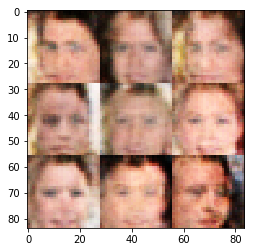

Epoch: 1/1, Batch: 5810/6331 Discriminator Loss: 1.3968 Generator Loss: 0.8699
Epoch: 1/1, Batch: 5820/6331 Discriminator Loss: 1.3875 Generator Loss: 0.7517
Epoch: 1/1, Batch: 5830/6331 Discriminator Loss: 1.3791 Generator Loss: 0.7717
Epoch: 1/1, Batch: 5840/6331 Discriminator Loss: 1.3867 Generator Loss: 0.7007
Epoch: 1/1, Batch: 5850/6331 Discriminator Loss: 1.3910 Generator Loss: 0.8313
Epoch: 1/1, Batch: 5860/6331 Discriminator Loss: 1.3914 Generator Loss: 0.7880
Epoch: 1/1, Batch: 5870/6331 Discriminator Loss: 1.3882 Generator Loss: 0.7364
Epoch: 1/1, Batch: 5880/6331 Discriminator Loss: 1.3880 Generator Loss: 0.7433
Epoch: 1/1, Batch: 5890/6331 Discriminator Loss: 1.3813 Generator Loss: 0.7644
Epoch: 1/1, Batch: 5900/6331 Discriminator Loss: 1.4080 Generator Loss: 0.6767


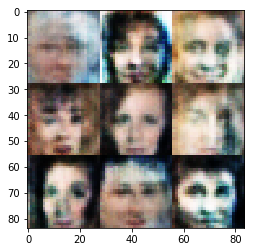

Epoch: 1/1, Batch: 5910/6331 Discriminator Loss: 1.4035 Generator Loss: 0.8104
Epoch: 1/1, Batch: 5920/6331 Discriminator Loss: 1.3745 Generator Loss: 0.8070
Epoch: 1/1, Batch: 5930/6331 Discriminator Loss: 1.3879 Generator Loss: 0.8519
Epoch: 1/1, Batch: 5940/6331 Discriminator Loss: 1.4154 Generator Loss: 0.9282
Epoch: 1/1, Batch: 5950/6331 Discriminator Loss: 1.3833 Generator Loss: 0.7958
Epoch: 1/1, Batch: 5960/6331 Discriminator Loss: 1.3884 Generator Loss: 0.7578
Epoch: 1/1, Batch: 5970/6331 Discriminator Loss: 1.3748 Generator Loss: 0.7891
Epoch: 1/1, Batch: 5980/6331 Discriminator Loss: 1.4038 Generator Loss: 0.6968
Epoch: 1/1, Batch: 5990/6331 Discriminator Loss: 1.3749 Generator Loss: 0.7665
Epoch: 1/1, Batch: 6000/6331 Discriminator Loss: 1.3965 Generator Loss: 0.8754


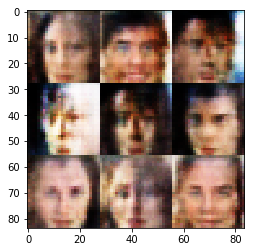

Epoch: 1/1, Batch: 6010/6331 Discriminator Loss: 1.4011 Generator Loss: 0.8655
Epoch: 1/1, Batch: 6020/6331 Discriminator Loss: 1.3767 Generator Loss: 0.7574
Epoch: 1/1, Batch: 6030/6331 Discriminator Loss: 1.4000 Generator Loss: 0.7906
Epoch: 1/1, Batch: 6040/6331 Discriminator Loss: 1.3803 Generator Loss: 0.7075
Epoch: 1/1, Batch: 6050/6331 Discriminator Loss: 1.3723 Generator Loss: 0.7999
Epoch: 1/1, Batch: 6060/6331 Discriminator Loss: 1.3781 Generator Loss: 0.7971
Epoch: 1/1, Batch: 6070/6331 Discriminator Loss: 1.4132 Generator Loss: 0.6668
Epoch: 1/1, Batch: 6080/6331 Discriminator Loss: 1.3810 Generator Loss: 0.7702
Epoch: 1/1, Batch: 6090/6331 Discriminator Loss: 1.3877 Generator Loss: 0.7840
Epoch: 1/1, Batch: 6100/6331 Discriminator Loss: 1.3869 Generator Loss: 0.7795


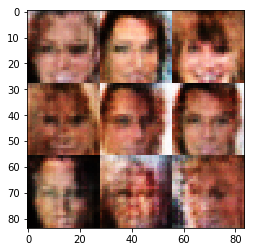

Epoch: 1/1, Batch: 6110/6331 Discriminator Loss: 1.3794 Generator Loss: 0.7671
Epoch: 1/1, Batch: 6120/6331 Discriminator Loss: 1.3915 Generator Loss: 0.7154
Epoch: 1/1, Batch: 6130/6331 Discriminator Loss: 1.3999 Generator Loss: 0.7401
Epoch: 1/1, Batch: 6140/6331 Discriminator Loss: 1.3805 Generator Loss: 0.7602
Epoch: 1/1, Batch: 6150/6331 Discriminator Loss: 1.3855 Generator Loss: 0.7429
Epoch: 1/1, Batch: 6160/6331 Discriminator Loss: 1.3862 Generator Loss: 0.8024
Epoch: 1/1, Batch: 6170/6331 Discriminator Loss: 1.3937 Generator Loss: 0.7315
Epoch: 1/1, Batch: 6180/6331 Discriminator Loss: 1.3979 Generator Loss: 0.6710
Epoch: 1/1, Batch: 6190/6331 Discriminator Loss: 1.3863 Generator Loss: 0.7314
Epoch: 1/1, Batch: 6200/6331 Discriminator Loss: 1.3876 Generator Loss: 0.7869


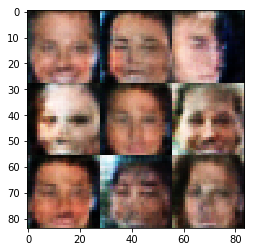

Epoch: 1/1, Batch: 6210/6331 Discriminator Loss: 1.3891 Generator Loss: 0.8515
Epoch: 1/1, Batch: 6220/6331 Discriminator Loss: 1.3866 Generator Loss: 0.8195
Epoch: 1/1, Batch: 6230/6331 Discriminator Loss: 1.3901 Generator Loss: 0.9054
Epoch: 1/1, Batch: 6240/6331 Discriminator Loss: 1.3766 Generator Loss: 0.8253
Epoch: 1/1, Batch: 6250/6331 Discriminator Loss: 1.3975 Generator Loss: 0.7016
Epoch: 1/1, Batch: 6260/6331 Discriminator Loss: 1.3820 Generator Loss: 0.7602
Epoch: 1/1, Batch: 6270/6331 Discriminator Loss: 1.3914 Generator Loss: 0.7689
Epoch: 1/1, Batch: 6280/6331 Discriminator Loss: 1.4006 Generator Loss: 0.9061
Epoch: 1/1, Batch: 6290/6331 Discriminator Loss: 1.3774 Generator Loss: 0.8127
Epoch: 1/1, Batch: 6300/6331 Discriminator Loss: 1.3887 Generator Loss: 0.7913


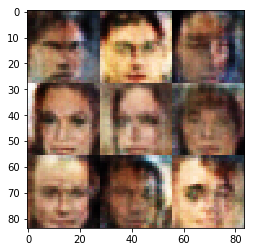

Epoch: 1/1, Batch: 6310/6331 Discriminator Loss: 1.3856 Generator Loss: 0.8152
Epoch: 1/1, Batch: 6320/6331 Discriminator Loss: 1.3892 Generator Loss: 0.7879
Epoch: 1/1, Batch: 6330/6331 Discriminator Loss: 1.3839 Generator Loss: 0.8317


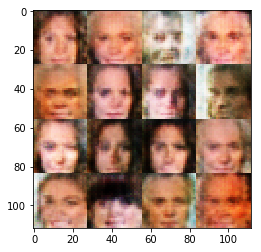

In [27]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.